<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Modèles de Markov cachés</div>

# Introduction

Depuis quelques années, de nombreuses technologies sont capables de comprendre le langage des Hommes, de comprendre le sens de leurs phrases et sont même capables de leur répondre. On peut citer le système Siri d'Apple ou Alexa d'Amazon. De plus, de nombreuses messageries instanées, telle que Messenger par exemple, sont capables de nous proposer notre prochain mot lorqu'on écrit un message.  
Mais comment cela est-il possible ?

Toutes les applications que l'on vient de citer font partie d'un domaine de l'intelligence artificielle que l'on appelle *traitement du langage naturel* (ou *natural language processing*). Il inclut entre autre la reconnaissance vocale, la synthèse vocale, la génération de texte ou encore l'étiquetage morpho-syntaxique (*Part-of-Speech tagging*). L'une des principales caractéristique du langage est sa temporalité : un mot ne fait sens dans une phrase parce qu'il est entouré d'un contexte. Les chercheurs n'ont pas attendu l'avènement de l'apprentissage profond et des réseaux de neurones avant de s'intéresser à cette problématique, et de construire des modèles permettant à un ordinateur de comprendre le langage des Hommes.

Les **modèles de Markov cachés** font partie des tout premiers modèles utilisés en traitement du langage naturel dès les années 1960. Ils généralisent les chaînes de Markov, très bien connues dans le domaine des probabilités, et ouvrent de nouveaux horizons. L'hypothèse markovienne (que l'on définiera) permet de prendre en compte la temporalité, le contexte, en apportant des informations sur l'instant précédent dans la prédiction à l'instant courrant. C'est pourquoi ces modèles semblent adaptés au traitement du langage naturel.  

Dans ce notebook, après avoir introduit les notions essentielles des chaînes de Markov, nous présenterons la théorie des modèles de Markov cachés, les trois problèmes fondamentaux ainsi que leurs méthodes de résolution. Enfin, nous construirons un étiqueteur morpho-syntaxique à l'aide d'un modèle de Markov caché.

1. [Introduction aux chaînes de Markov](#sec1)
2. [Théorie des chaînes de Markov chachées](#sec2)
3. [Les trois problèmes fondamentaux](#sec3)
4. [Cas d'application : Part-of-Speech tagging](#sec4)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. <a id="sec1"></a> Introdution aux chaînes de Markov

Dans un premier temps, nous allons présenter les principales définitions et proriétés de la théorie des chaînes de Markov. Pour plus de détails, je vous invite à consulter ce [cours](https://personnel.isae-supaero.fr/IMG/pdf/notes_de_cours.pdf) très complet.

<div class="alert alert-info"> <b> Notation </b> : On note $(X_n)_{n\geq0} \in E^{\mathbb{N}}$ une suite de variables aléatoires indexée sur $\mathbb{N}$ et à valeurs dans un ensemble $E$. On la notera plus couramment $(X_n)$ ou encore $X$.</div>

## 1.1 Définitions

<div class="alert alert-danger"><b>Définition 1.1 [Chaîne de Markov]</b> Une suite de variables aléatoires $(X_n)_{n\geq0}$ à valeurs dans un espace d’état dénombrable (fini ou infini) $E$ est une chaîne de Markov si pour tout $n ≥ 0$ et tout $x_0,...,x_{n+1} \in E$ on a : $$\mathbb{P}(X_{n+1} = x_{n+1} | X_n = x_n,...,X_0 = x_0) = P(X_{n+1} = x_{n+1} | X_n = x_n)$$

Si par ailleurs $\mathbb{P}(X_{n+1} =x_{n+1} |X_n =x_n) = \mathbb{P}(X_1 =x_{n+1} |X_0 = x_n)$, on dit que $(X_n)$ est <i>homogène en temps</i>. </div>

  
En d'autres termes, une suite de variables aléatoires $(X_n)$ à valeurs dans un espace d’état dénombrable $E$ est donc une chaîne de Markov si conditionnellement au présent, futur et passé sont indépendants. Un exemple trivial de chaîne de Markov est le cas où les $X_i$ sont indépendantes et identiquement distribuées (i.i.d.). 

<div class="alert alert-success"> Dans tout le notebook, conformément à nos cas d'applications, nous allons considérer des chaînes de Markov dans un espace d'état $E$ <b>dénombrable</b> (fini ou infini) et <b>homogènes en temps.</b></div>

Pour une chaîne de Markov homogène en temps, la probabilité $\mathbb{P}(X_{n+1} = y | X_n = x)$ ne dépend donc pas du temps (ie $n$) : on appelle cette probabilité **probabilité de transition** (de $x$ à $y$) et on la note $$p_{xy} =P(X_{n+1} = y|X_n = x)=P(X_1 = y|X_0 = x)$$ 

<div class="alert alert-danger"><b>Définition 1.2 [Matrice de transition] </b> L’ensemble des probabilités de transition définit la matrice de transition notée $P$ et définie par : $$P=(p_{xy})_{x,y \in E}$$</div>

Si $E$ est infini, $P$ est alors une "matrice infinie".  
$P$ est une matrice stochastique, c'est à dire qu'elle vérifie les propriétés suivantes : 

$$
\left\{
    \begin{array}{rl}
        \forall x,y \in E, & p_{xy} \geq 0 \\
        \forall x \in E, & \sum_{y\in E} p_{xy} = 1
    \end{array}
\right.
$$

Les deux conditions nous permettent d'affirmer que $\forall x,y \in E,  p_{xy} \in [0,1]$. Il s'agit donc bien de probabilités. De plus, la seconde condition nous dit que pour chaque ligne, la somme de ses éléments vaut $1$. Cela veut dire qu'en partant d'un état $x \in E$ à l'instant $n$, on va aller dans un état de $E$ à l'instant $n+1$ presque sûrement ($\mathbb{P}(X_1 \in E | X_0 = x) = 1$ pour tout $x \in E$).

## 1.2 Premiers exemples

Donnons quelques exemples classiques de chaînes de Markov homogènes en temps et sur un espace d'état dénombrable : 

* **Exemple 1** : Chaîne de Markov à 2 états sur $E = \{0,1\}$.
<img src="Images/Markov.png" width="600px"></img>
On a : $p_{0,1} = p_{1,0} = 1 - p_{0,0} = 1 - p_{1,1} = p \in [0,1]$, et donc la matrice de transition est donnée par $P = \begin{pmatrix} 1-p & p \\ p & 1-p \end{pmatrix}$ qui est bien stochastique.
En d'autres termes, on change d'état avec une probabilité $p$ et on reste dans le même état avec une probabilité $1-p$.  

* **Exemple 2** : Marche aléatoire réfléchie sur $E = \mathbb{N}$ : 
<img src="Images/MarkovN.png" width="600px"></img>
On a : $p_{x,x+1} = 1 - p_{x,x-1} = p$ pour $x>0$ et $p_{0,1} = 1 - p_{0,0} = p$, et donc la matrice de transition est donnée par la "matrice" infinie $P = \begin{pmatrix} 1-p & p & 0 & 0 & ...\\ 
                                    1-p & 0 & p & 0 & ...\\
                                    0 & 1-p & 0 & p & ...\\
                                    0 & 0 & 1-p & 0 & ...\\
                                    ... & ... & ...& ... & ...\end{pmatrix}$ 
qui est stochastique. Autrement dit, dans tous les cas, on va à droite avec une probabilité $p$. En revanche, si on est en $x>0$, on va à gauche avec une probabilité $1-p$ et si on est en $x=0$, on reste en $0$ avec une probabilité $1-p$.

In [20]:
def marche_aleatoire_N(p,n_max = 100):
    """Retourne une réalisation de la marche aléatoire réfléchie sur N entre 0 et n_max
    0 <= p <= 1
    n_max : entier naturel"""
    steps = np.random.choice([-1,1],replace=True,size = n_max,p=[1-p,p])
    print(steps)
    marche = np.zeros(n_max+1)
    for n in range(1,n_max+1):
        if marche[n-1] == 0:
            marche[n] = (1 if steps[n-1] == 1 else 0)
        else:
            marche[n] = marche[n-1] + steps[n-1]
    return marche

[-1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1]
[ 1 -1 -1  1 -1]
[-1  1 -1  1 -1]
[-1  1  1 -1 -1]
[1 1 1 1 1]
[ 1  1 -1  1  1]
[ 1  1  1 -1  1]
[ 1 -1  1  1 -1]


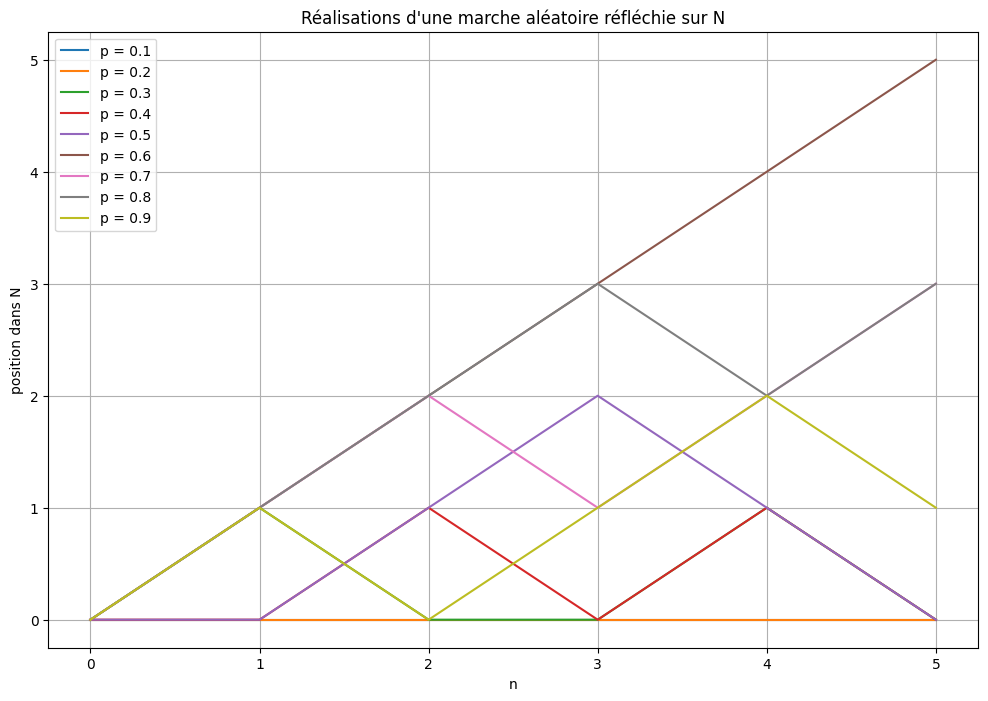

In [21]:
probas = np.arange(.1,1,.1)
fig,ax = plt.subplots(figsize=(12,8))
for p in probas:
    marche = marche_aleatoire_N(p,5)
    ax.plot(marche,label="p = " + str(np.round(p,1)))
ax.grid()
ax.set_xlabel("n")
ax.set_ylabel("position dans N")
ax.set_title("Réalisations d'une marche aléatoire réfléchie sur N")
ax.legend()

* **Exemple fil rouge** : Chaîne de Markov à 3 états : 
<img src="Images/FilRouge.png" width="600px"></img>
Considérons la chaîne de Markov représentée par ce graphe d'état. Pour $n\geq0$, on pose $X_n$ le temps qu'il fait le jour $n$, de telle sorte que la météo au jour $n$ ne dépend que de la météo au jour $n-1$. $(X_n)$ est donc bien une chaîne de Markov et elle peut prendre 3 valeurs : *sunshine* (état $0$), *rain* (état $1$) et *snow* (état $2$).  
La matrice de transition est donnée par $P = \begin{pmatrix} 0.5 & 0.3 & 0.2\\ 
                                    0.45 & 0.45 & 0.1 \\
                                    0.4 & 0.3 & 0.3 \end{pmatrix}$ 
qui est stochastique. 
Par exemple, s'il pleut lundi, il y a 45% de chance qu'il fasse beau mardi et 10% de chance qu'il neige mardi.

<div class="alert alert-success"> <b> Convention </b> : Pour toutes les parties informatiques, nous allons utiliser des numpy arrays pour manipuler les différentes matrices et les vecteurs. L'indexation nécessite l'utilisation d'entiers et non d'états tels que "sunshine" par exemple.

C'est pourquoi nous allons associer un entier à chaque état $x \in E$. Nous allons stocker les correspondances dans un dictionnaire. Dans l'exemple fil rouge, on a : <i>sunshine : 0</i>, <i>rain : 1</i> et <i>snow : 2</i></div>

Démarrons l'implémentation de notre exemple fil rouge :

In [22]:
#Définition de l'espace d'états
etats = {"sunshine" : 0, "rain" : 1, "snow" : 2}
inv_etats = dict((n,k) for k, n in etats.items())
liste_etats = list(etats.keys())

In [23]:
#Définition de la matrice de transition
df = pd.DataFrame(columns=liste_etats, index=liste_etats)
df.loc[liste_etats[0]] = [.5,.3,.2]
df.loc[liste_etats[1]] = [.45,.45,.1]
df.loc[liste_etats[2]] = [.4,.3,.3]
print("Matrice de transition :\n", df)

Matrice de transition :
          sunshine  rain snow
sunshine      0.5   0.3  0.2
rain         0.45  0.45  0.1
snow          0.4   0.3  0.3


In [24]:
P = df.values.astype('float')
n_etat = P.shape[0]
print(P)
#Vérification des conditions d'une matrice stochastique
sum_per_row = np.sum(P,axis = 1)
is_positive = P>=0
if (np.sum(is_positive) == n_etat**2) and (np.sum(sum_per_row == n_etat*[1]) == n_etat):
    print("P est stochastique")
else:
    print("P n'est pas stochastique")

[[0.5  0.3  0.2 ]
 [0.45 0.45 0.1 ]
 [0.4  0.3  0.3 ]]
P est stochastique


In [25]:
def markov_chain(n_max):
    """Retourne une réalisation entre 0 et n_max de l'exemple fil rouge en partant de 0 à l'instant 0
    n_max : entier naturel"""
    X_n = np.zeros(n_max+1,dtype=int)
    for j in range(n_max):
        X_n[j+1] = np.random.choice([0,1,2],size=1,p=list(P[X_n[j]]))
    return X_n

print("Exemples de réalisation de la chaîne de Markov de l'exemple fil rouge : \n ")
for i in range(5):
    X_n = markov_chain(5)
    print("{} : {}".format(i+1,[inv_etats[x] for x in X_n]))

Exemples de réalisation de la chaîne de Markov de l'exemple fil rouge : 
 
1 : ['sunshine', 'sunshine', 'rain', 'snow', 'sunshine', 'snow']
2 : ['sunshine', 'sunshine', 'snow', 'rain', 'rain', 'sunshine']
3 : ['sunshine', 'sunshine', 'snow', 'rain', 'sunshine', 'rain']
4 : ['sunshine', 'sunshine', 'sunshine', 'sunshine', 'sunshine', 'sunshine']
5 : ['sunshine', 'sunshine', 'snow', 'sunshine', 'rain', 'snow']


/tmp/ipykernel_472/3019011315.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_n[j+1] = np.random.choice([0,1,2],size=1,p=list(P[X_n[j]]))


## 1.3 Loi d'une chaîne de Markov

<div class="alert alert-danger"><b>Définition 1.3 [Loi d’un processus] </b> La loi d’une suite de variables aléatoires $(X_n)_{n\geq0}$ est la donnée de $\mathbb{P}(X_0 = x_0,...,X_n = x_n)$ pour tout $n \geq 0$ et tout $x_0,...,x_n \in E$.</div>

<div class="alert alert-info"> <b> Notation </b> : Pour simplifier à partir de maintenant, pour tout $n\geq0$ on note $X_0^n = (X_k)_{k \in [\![0,n]\!]}$ la chaîne tuée à l’instant $n$ et $x_0^n = (x_k)_{k \in [\![0,n]\!]}$ une séquence d'états entre les instants $0$ et $n$.</div>

<div class="alert alert-warning"><b>Théorème 1.1 </b> : Si $X$ est une chaîne de Markov de matrice de transition $P$, alors pour tout $n\geq0$ et $x_0^n \in E^{n+1}$, on a : $$\mathbb{P}(X_0^n = x_0^n) = \mathbb{P}(X_0 = x_0)\prod_{i=1}^n p_{x_{i−1}x_i}.$$</div>

Pour calculer la loi de la chaîne de Markov, nous avons donc besoin de conditions initiales $\mathbb{P}(X_0 = 0)$, $\mathbb{P}(X_0 = 1)$ et $\mathbb{P}(X_0 = 2)$. Pour l'instant, dans notre exemple fil rouge on ne les connaît pas. On va donc supposer que l'on part de $0$ de telle sorte que $\mathbb{P}(X_0 = 0) = 1$, et on va calculer la probabilité d'une certaine réalisation $x_0,...,x_n \in E$ avec la formule ci-dessus.

In [26]:
#Sachant que l'on part de 0, calcul de la probabilité d'une réalisation
n = 3
realisation = np.random.randint(0,3,n+1)
print(realisation)
realisation[0] = 0 #X0 = 0
realisation_etat = [inv_etats[n] for n in realisation]
proba = 1
for i in range(1,n+1):
    proba *= P[realisation[i-1],realisation[i]]
print("P(X_0^{} = {}) = {}" .format(n, realisation_etat,proba))

[1 2 1 2]
P(X_0^3 = ['sunshine', 'snow', 'rain', 'snow']) = 0.006


La matrice $P$ ne caractérise pas pleinement la loi de $X$ : il faut une condition initiale $(\mathbb{P}(X_0 = x_0))_{x_0 \in E}$. 

<div class="alert alert-info"> <b> Notation </b> : À partir de maintenant, on notera $\pi_0$ la condition initiale, avec $\pi_0 = (\pi_0(x))_{x \in E}$ et $\pi_0(x) = \mathbb{P}(X_0 = x)$. 
    
On note également $\pi_n$ la loi de $X_n$, i.e. $\pi_n = (\pi_n(x))_{x \in E}$ avec $\pi_n(x) = \mathbb{P}(X_n = x)$.
    
Pour tout $n\geq0$, $\pi_n$ est donc un vecteur colonne de $[0,1]^{E}$ contenant les probabilités $\mathbb{P}(X_n = x)$ pour tout $x\in E$.</div>


<div class="alert alert-warning"><b>Théorème 1.2 </b> : La suite des lois $(\pi_n)_{n \geq 0}$ vérifie le système dynamique linéaire déterministe suivant : $$\forall n \geq 0, \ \pi^T_{n+1} = \pi^T_n P$$
En particulier, $\forall n \geq 0, \ \pi_n^T = \pi_0^T P^n$.</div>

La loi de $(X_n)$ est alors pleinement définit par $P$ et $\pi_0$. On peut donc désigner une chaîne de Markov homogène en temps par le couple $(\pi_0,P)$.

Démonstration du théorème 1.2 : Pour $n \geq 0$ et $x \in E$ on a : $$\pi_{n+1}(x) = \mathbb{P}(X_{n+1} = x) = \sum_{y\in E}\mathbb{P}(X_{n+1} =x|X_n =y)\mathbb{P}(X_n = y) = \sum_{y \in E} p_{yx}\pi_n(y) = (\pi_n^T P)_x$$

Dans notre exemple fil rouge, nous allons fixer une condition initiale (ie définir $\pi_0$) et nous serons alors capables de calculer la loi de $X_n$ pour tout $n\geq0$ avec la dernière formule.

In [27]:
#Loi initiale
pi_0 = np.array([.2, .5, .3])
pi_0

array([0.2, 0.5, 0.3])

In [28]:
#Calcul de pi_n
N = 10
pi = pi_0
print("Loi de X_n pour n dans [0,{}] : \n".format(N))
for n in range(N):
    pi = pi@P
    print("P(X%d = sunshine) = %f, P(X%d = rain) = %f, P(X%d = snow) = %f" % (n+1,pi[0],n+1,pi[1],n+1,pi[2]))

Loi de X_n pour n dans [0,10] : 

P(X1 = sunshine) = 0.445000, P(X1 = rain) = 0.375000, P(X1 = snow) = 0.180000
P(X2 = sunshine) = 0.463250, P(X2 = rain) = 0.356250, P(X2 = snow) = 0.180500
P(X3 = sunshine) = 0.464137, P(X3 = rain) = 0.353437, P(X3 = snow) = 0.182425
P(X4 = sunshine) = 0.464086, P(X4 = rain) = 0.353016, P(X4 = snow) = 0.182899
P(X5 = sunshine) = 0.464059, P(X5 = rain) = 0.352952, P(X5 = snow) = 0.182988
P(X6 = sunshine) = 0.464054, P(X6 = rain) = 0.352943, P(X6 = snow) = 0.183004
P(X7 = sunshine) = 0.464052, P(X7 = rain) = 0.352941, P(X7 = snow) = 0.183006
P(X8 = sunshine) = 0.464052, P(X8 = rain) = 0.352941, P(X8 = snow) = 0.183006
P(X9 = sunshine) = 0.464052, P(X9 = rain) = 0.352941, P(X9 = snow) = 0.183007
P(X10 = sunshine) = 0.464052, P(X10 = rain) = 0.352941, P(X10 = snow) = 0.183007


Nous savons désormais ce qu'est une chaîne de Markov et nous avons énoncé quelques unes de ses propriétés essentielles. Nous avons toutes les bases nécessaires et nous sommmes prêts à s'attaquer à la théorie des chaînes de Markov cachées. 

# 2. <a id="sec2"></a> Théorie des modèles de Markov cachés

[L'INRIA](http://people.bordeaux.inria.fr/pierre.delmoral/hmm-cappe-moulines-ryden.pdf) présente la théorie des modèles de Markov cachés de manière très mathématique et très formelle (pour les purs matheux) tandis que [Agro ParisTech](http://www2.agroparistech.fr/ufr-info/membres/cornuejols/Teaching/Master-ISI/ISI-10/livre2-v3(ac)-ch-12.pdf), [Kohlschein](https://www.tcs.rwth-aachen.de/lehre/PRICS/WS2006/kohlschein.pdf) et [Stanford](https://web.stanford.edu/~jurafsky/slp3/A.pdf) donnent une version plus accessible et plus orientée algorithmie. Ne s'agissant pas d'un cours de mathématiques poussées, nous allons nous contenter l'approche algorithmie. Mais avant toute chose, définissons tout de même ce qu'est un modèle de Markov caché.

Dans cette partie nous allons donner les définitions principales de la théorie des modèles de Markov caché ainsi que ses principales propriétés. Nous allons les illustrer à l'aide de l'exemple fil rouge.

## 2.1 Motivations - cas de l'exemple fil rouge

Afin de comprendre l'intérêt de la théorie des modèles de Markov cachés, complétons notre exemple fil rouge. Nous avons toujours notre chaîne de Markov $(X_n)$ à valeurs dans un espace d'état $E = \{sunshine,rain,snow\}$ et de matrice de transition est $P = \begin{pmatrix} 0.5 & 0.3 & 0.2\\ 
                                    0.45 & 0.45 & 0.1 \\
                                    0.4 & 0.3 & 0.3 \end{pmatrix}$.  
                                    
Supposons désormais que nous sommes dans une pièce sans fenêtres et sans isolation thermique (oui ce n'est pas très très confortable mais c'est pour la science :) ), de telle sorte qu'on ne peut pas voir le temps qu'il fait, mais qu'on peut savoir s'il fait chaud ou froid dehors. Le temps nous est donc caché, invisible, mais chaque jour nous avons accès à une observation, la température, nous permettant d'avoir un indice sur la météo.  
$(X_n)$ devient donc une **suite cachée** et chaque jour la température est une **observation**. Nous faisons l'hypothèse que l'observation effectuée le jour $n$ ne dépend uniquement de la météo ce jour-là.

Supposons alors que l'on a les probabilités suivantes : 
* $\mathbb{P}(cold|sunshine) = 0.3$ et $\mathbb{P}(hot|sunshine) = 0.7$ 
* $\mathbb{P}(cold|rain) = 0.8$ et $\mathbb{P}(hot|rain) = 0.2$ 
* $\mathbb{P}(cold|snow) = 1$ et $\mathbb{P}(hot|snow) = 0$   

Notre graphe d'état devient donc :

<img src="Images/HiddenFilRouge.png" width="600px"></img>

Par exemple, s'il pleut lundi, il y a 80% de chances qu'il fasse froid lundi et 20% de chances qu'il fasse chaud.  

Nous venons de convertir notre chaîne de Markov fil rouge en un **modèle de Markov caché**, avec une suite cachée à laquelle nous n'avons pas accès (la météo) et une suite d'observations (la température) à laquelle nous avons accès. Formalisons cette idée.

## 2.2 Définitions

Le modèle de Markov caché généralise le modèle de Markov observable car il produit une séquence en utilisant deux suites de variables aléatoires : l’une cachée et l’autre observable.

<div class="alert alert-danger"><b>Définition 2.1 [Chaîne de Markov cachée]</b> Un modèle de Markov caché est la donnée de deux suites de variables aléatoires : 
<li>la suite cachée, $(X_n)_{n\geq0}$, qui est une chaîne de Markov "classique" homogène en temps et à valeurs dans un espace d'état dénombrable $E$  </li>
<li>la suite des observations, $(O_n)_{n\geq0}$, qui est une suite de variables aléatoires et à valeurs dans un ensemble dénombrable $\mathcal{V}$ appelé <i>vocabulaire</i>.</li>

Pour tout $n\geq0$, ces deux suites vérifient la relation : $$\forall v_0,...,v_n \in \mathcal{V}, \forall x_0,...,x_n \in E, , \mathbb{P}(O_n = v_n | X_0^n = x_0^n, O_0^{n-1} = v_0^{n-1}) = \mathbb{P}(O_n = v_n | X_n = x_n)$$
    
Si par ailleurs $\forall n\geq0, \forall v \in \mathcal{V}, \forall x \in E, \mathbb{P}(O_n = v | X_n = x) = \mathbb{P}(O_0 = v | X_0 = x)$, le modèle est dit <i>stationnaire</i>.
</div>

Autrement dit, pour un modèle de Markov caché stationnaire, pour $x\in E$ et $v \in \mathcal{V}$, la probabilité $\mathbb{P}(O_n = v | X_n = x)$ ne dépend pas du temps : on appelle cette probabilité **probabilité d'émission** (de $x$ à $v$) et on la note $$b_{xv} = \mathbb{P}(O_n = v|X_n = x) = \mathbb{P}(O_0 = v|X_0 = x)$$ 

<div class="alert alert-success"> À partir de maintenant et conformément à nos cas d'applications, nous allons considérer des modèles de Markov cachés dans un espace d'état $E$ <b>fini</b> (de cardinal $N \geq1$), <b>homogènes en temps</b>, avec un <b>vocabulaire fini</b> (de cardinal $|\mathcal{V}|$) et <b>stationnaires</b>.</div>

<div class="alert alert-danger"><b>Définition 2.2 [Matrice d'émission]</b> L’ensemble des probabilités d'émission définit la matrice d'émission notée $B$ et définie par : $$B=(b_{xv})_{x \in E, v\in\mathcal{V}}$$ </div>
De la même manière que la matrice de transition de la chaîne de Markov, la matrice d'émission est une matrice stochastique, c'est à dire qu'elle vérifie : 

$$
\left\{
    \begin{array}{rl}
        \forall x \in E, \forall v \in \mathcal{V}, & b_{xv} \geq 0 \\
        \forall x \in E, & \sum_{v\in \mathcal{V}} b_{xv} = 1
    \end{array}
\right.
$$


<div class="alert alert-success"> <b> Convention </b> Pour la même raison que pour les états, nous allons associer un entier à chaque élément du vocabulaire pour l'indexation de la matrice d'émission : <i>cold : 0</i> et <i>hot : 1</i>.</div>


Implémentons la matrice d'émission de notre chaîne de Markov cachée : 

In [47]:
#Définition du vocabulaire
vocabulaire = {'Cold':0, 'Hot':1}
inv_vocabulaire = dict((n,k) for k, n in vocabulaire.items())
list_vocabulaire = list(vocabulaire.keys())

In [48]:
#Définition de la matrice d'émission
b_df = pd.DataFrame(columns=list_vocabulaire, index=liste_etats)
b_df.loc[liste_etats[0]] = [.3,.7]
b_df.loc[liste_etats[1]] = [0.8,0.2]
b_df.loc[liste_etats[2]] = [1,0]
B = b_df.values.astype("float")
print("\n Matrice d'émission :\n",b_df)


 Matrice d'émission :
          Cold  Hot
sunshine  0.3  0.7
rain      0.8  0.2
snow        1    0


Pour générer une séquence d'observations à partir d'un modèle de Markov caché, il faut suivre la procédure suivante : 
* 1 - tirer l'état initial $X_0$ selon la loi initiale $\pi_0$
* 2 - tirer l'observation initiale $O_0$ suivant les probabilités d'émission correspondantes à $X_0$
* 3 - à partir de l'état $X_i$ à l'instant $i$, aller à l'état suivant $X_{i+1}$ suivant les probabilités de transition
* 4 - tirer l'observation $O_{i+1}$ à l'instant $i+1$ suivant les probabilités d'émission
* 5 - retourner à l'étape 3 et recommencer jusqu'à l'arrêt


In [91]:
def hidden_markov_model(n,pi_0,P,B): 
    """Génération d'une séquence de (n+1) états et de (n+1) observations entre les instants 0 et n
    n : entier naturel
    pi_0 : distribution initiale de la suite cachée
    P : matrice de transition
    B : matrice d'émission
    """
    X_n = np.zeros(n+1,dtype=int)
    O_n = np.zeros(n+1,dtype=int)
    print(X_n)
    E = list(range(P.shape[0])) #Espace d'états
    V = list(range(B.shape[1])) #Vocabulaire
    
    #initialisation
    X_n[0] = np.random.choice(E,size=1,p=pi_0)
    O_n[0] = np.random.choice(V,size=1,p = list(B[X_n[0]]))
    print(X_n)
    #récurrence
    for i in range(n):
        X_n[i+1] = np.random.choice(E,size=1,p = list(P[X_n[i]]))
        O_n[i+1] = np.random.choice(V,size=1,p = list(B[X_n[i+1]]))
        print(X_n)
    return X_n,O_n

In [98]:
X,O = hidden_markov_model(5,pi_0,P,B)
print("Exemple de réalisation du modèle de Markov caché : \n")
for i in range(len(X)):
    print("X_" + str(i) + " = " + inv_etats[X[i]] +", O_" + str(i) + " = "+ inv_vocabulaire[O[i]])

[0 0 0 0 0 0]
[1 0 0 0 0 0]
[1 1 0 0 0 0]
[1 1 0 0 0 0]
[1 1 0 1 0 0]
[1 1 0 1 0 0]
[1 1 0 1 0 0]
Exemple de réalisation du modèle de Markov caché : 

X_0 = rain, O_0 = Cold
X_1 = rain, O_1 = Cold
X_2 = sunshine, O_2 = Cold
X_3 = rain, O_3 = Cold
X_4 = sunshine, O_4 = Hot
X_5 = sunshine, O_5 = Hot


/tmp/ipykernel_472/396646324.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_n[0] = np.random.choice(E,size=1,p=pi_0)
/tmp/ipykernel_472/396646324.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  O_n[0] = np.random.choice(V,size=1,p = list(B[X_n[0]]))
/tmp/ipykernel_472/396646324.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_n[i+1] = np.random.choice(E,size=1,p = list(P[X_n[i]]))
/tmp/ipykernel_472/396646324.py:21: DeprecationWarning: Conversion

## 2.3 Loi du processus $(X,O)$

De la même manière que pour les chaînes de Markov classiques, intéressons nous à la loi de la suite $(X_n,O_n)_{n\geq0}$.

<div class="alert alert-warning"><b>Théorème 2.1 </b> : Pour tout $n \geq 0$, tout $x_0, ..., x_n \in E$ et pour tout $v_0, ..., v_n \in \mathcal{V}$, on a :
$$\mathbb{P}(X_0^n = x_0^n, O_0^n = v_0^n) = \pi_0(x_0)\prod_{i=0}^n b_{x_iv_i} \prod_{i=1}^n p_{x_{i-1}x_i}$$
</div>

Démonstration du théorème 2.1 : Soit $x_0, ..., x_n \in E$ et $v_0, ..., v_n \in \mathcal{V}$. On a : 

\begin{align}
\mathbb{P}(X_0^n = x_0^n, O_0^n = v_0^n) &= \mathbb{P}(O_0^n = v_0^n | X_0^n = x_0^n) \mathbb{P}(X_0^n = x_0^n) \\
&= \mathbb{P}(X_0^n = x_0^n) \mathbb{P}(O_0 = v_0 | X_0^n = x_0^n) \prod_{i=1}^n \mathbb{P}(O_i = v_i | X_0^n = x_0^n, O_0^{i-1} = v_0^{i-1})\\
&= \mathbb{P}(X_0^n = x_0^n) \prod_{i=0}^n \mathbb{P}(O_i = v_i | X_i = x_i) \ \ \ \text{par la propriété de Markov sur les observations} \\
&= \pi_0(x_0)\prod_{i=0}^n b_{x_iv_i} \prod_{i=1}^n p_{x_{i-1}x_i} 
\end{align}

Ce théorème nous permet d'affirmer que la loi du processus $(X,O)$ est donc entièrement déterminé par $\pi_0$, $P$ et $B$. De la même manière que pour les chaînes de Markov classiques, on peut désigner une chaîne de Makov caché par le triplet $(\pi_0,P,B)$.

In [33]:
n = 2
realisation = np.random.randint(0,3,n+1)
sequence_obs = np.random.randint(0,2,n+1)
realisation_etat = [inv_etats[n] for n in realisation]
observations_etat = [inv_vocabulaire[n] for n in sequence_obs]

In [45]:
#Calcul de la probabilité d'une réalisation de (X,O)
proba = pi_0[realisation[0]] * B[realisation[0],sequence_obs[0]]
for i in range(1,n+1):
    proba *= P[realisation[i-1],realisation[i]] * B[realisation[i],sequence_obs[i]]
print("P(X_0^{} = {},O_0^{} = {}) = {}".format(n, realisation_etat,n,observations_etat,proba))

P(X_0^2 = ['sunshine', 'snow', 'snow'],O_0^2 = ['Hot', 'Hot', 'Hot']) = 0.0


# 3. <a id="sec3"></a> Les trois problèmes fondamentaux

Lorsqu'un data scientist décide d'utiliser un modèle de Markov caché pour représenter un phénomène, par exemple en traitement du langage naturel, un gros problème se pose à lui : la suite d'états n'est pas accessible, il ne possède que la suite d'obervations. Deux types de situations sont alors possibles : 
* soit les paramètres $(\pi_0,P,B)$ sont connus et on peut alors faire des calculs sous ce modèle
* soit ils ne le sont pas, auquel cas on voudrait les déterminer à partir d'observations, comme le ferait un réseau de neurones

<div class="alert alert-info"> <b> Notation </b> : Dans toute cette partie, pour un modèle de Markov caché $\lambda = (\pi_0,P,B)$ et une séquence d'observations $v_0^n \in \mathcal{V}^{n+1}$, on note par $\mathbb{P}_\lambda(O_0^n = v_0^n)$ la probabilité que le modèle caché $\lambda$ ait émis la séquence $v_0^n$.</div>

<div class="alert alert-success"> <b> Convention </b> : En adéquation avec les correspondances <i>entier/état</i> et <i>entier/mot</i> que nous avons créées, les algorithmes de cette partie ne traiteront uniquement que des entiers (en d'autres termes : $E = [\![0,N-1]\!]$ et $\mathcal{V} = [\![0,|\mathcal{V}| - 1]\!]$) La conversion vers les états et les mots se feront grâce aux dictionnaires de correspondances.</div>

Étant donnée une séquence d'obervations $v_0^n \in \mathcal{V}^{n+1}$, il existe trois problèmes fondamentaux qui méritent notre attention et qui doivent être résolus : 

* **Problème 1 (calcul de probabilité)** : étant donné un modèle $\lambda = (\pi_0,P,B)$, calculer efficacement la probabilité d'observer cette séquence
* **Problème 2 (le déchiffrage)** : étant donné un modèle $\lambda = (\pi_0,P,B)$, déterminer la séquence d'états $x_0^n \in E^{n+1}$ correspondante la plus probable
* **Problème 3 (l'apprentissage)** : déterminer les paramètres du modèle $\lambda^* = (\pi_0^*,P^*,B^*)$ qui maximisent $\mathbb{P}_{\lambda}(O_0^n = v_0^n)$

Nous considérons toujours le modèle de Markov caché de notre exemple fil rouge dont les paramètres $\lambda = (\pi_0,P,B)$ sont donnés par :

In [46]:
print("Paramètres de notre exemple fil rouge : ")
print("\n - Conditions initiales : ")
print("pi_0 = " + str(pi_0))
print("\n - Matrice de transition : ")
print("P = " + str(P))
print("\n - Matrice d'émission : ")
print("B = " + str(B))

Paramètres de notre exemple fil rouge : 

 - Conditions initiales : 
pi_0 = [0.2 0.5 0.3]

 - Matrice de transition : 
P = [[0.5  0.3  0.2 ]
 [0.45 0.45 0.1 ]
 [0.4  0.3  0.3 ]]

 - Matrice d'émission : 
B = [[0.3 0.7]
 [0.8 0.2]
 [1.  0. ]]


Nous allons présenter dans cette partie les méthodes de résolution de ces trois problèmes. [Rabiner](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf) s'intéresse particulièrement à cette problématique.

## 3.1 Problème 1 : calcul de probabilité

<div class="alert alert-success"> <b> But </b> : Étant donné un modèle caché $\lambda = (\pi_0,P,B)$ et une séquence d'observations $v_0^n \in \mathcal{V}^{n+1}$, calculer $\mathbb{P}_\lambda(O_0^n = v_0^n)$.</div>

Dans le cas de notre exemple fil rouge, on veut par exemple déterminer la probabilité d'observer la séquence *hot-hot-cold-hot-cold*.

### 3.1.1 Première approche théorique

Théoriquement, ce problème est très simple à résoudre : connaissant le modèle $\lambda = (\pi_0,P,B)$, le théorème 2.1 nous donne la loi couplée $(X,O)$ et nous sommes capable de calculer la loi de la suite $(O_n)$ via la formule :$$\mathbb{P}_\lambda(O_0^n = v_0^n) = \sum_{x_0^n \in E^{n+1}} \mathbb{P}_\lambda(X_0^n = x_0^n, O_0^n = v_0^n) = \sum_{x_0^n \in E^{n+1}}\pi_0(x_0)\prod_{i=0}^n b_{x_iv_i} \prod_{i=1}^n p_{x_{i-1}x_i}$$
Cependant, nous aimerions pouvoir calculer cette probabilité informatiquement. Faisons alors un peu de dénombrement.  
Si $E$ est fini de cardinal $N>0$, alors $Card(E^{n+1}) = N^{n+1}$. La probabilité voulue est donc une somme de $N^{n+1}$ termes. Il y a donc $N^{n+1} - 1$ sommes à effectuer. De plus, chaque terme est composé de $2n+1$ produits.  
Pour calculer cette probabilité, il faut donc réaliser $(2n+1)N^{n+1}$ produits et $N^{n+1} - 1$ sommes, soit $2(n+1)N^{n+1} - 1 \approx 2nN^{n+1}$ opérations élémentaires.

In [30]:
#Calcul de la complexité dans l'exemple fil rouge
N = 3
n = 100
n_op = 2*n*N**(n+1)
print("{} opérations soit plus de 10^{}.".format(n_op,int(np.log10(np.float(n_op)))))

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Dans notre exemple fil rouge, l'espace d'état est composé de seulement 3 éléments. Pour calculer la probabilité de réalisation d'une séquence de $n = 100$ observations, il faut plus de $10^{50}$ opérations élémentaires. Je vous laisse imaginer le nombre d'opérations élémentaires qu'il faudrait si l'espace d'état était bien plus grand, comme c'est le cas dans des applications plus courantes.

Excepté pour des cas simplissimes, il est donc impossible de calculer la probabilité voulue informatiquement avec cette méthode. Il est donc nécessaire de développer une autre méthode pour calculer $\mathbb{P}_\lambda(O_0^n = v_0^n)$.

### 3.1.2 L'algorithme du Forward

Nous devons trouver un moyen plus efficace de calculer la probabilité $\mathbb{P}_\lambda(O_0^n = v_0^n)$. Heureusement, un tel algorithme existe : **l'algorithme du Forward** qui a une complexité en $\mathcal{O}(nN^2)$. L'astuce ici est de s'intéresser aux coefficients de Forward : 

<div class="alert alert-danger"><b> Définition 3.1 [Coefficient de forward]</b>$$\forall i \in [\![0,n]\!], \forall x \in E, \alpha_i(x) = \mathbb{P}_\lambda(O_0^{i} = v_0^{i}, X_i = x) $$</div> 

$\alpha_i(x)$ représente la probabilité d'observer la séquence tronquée $v_0^{i}$ et que la suite cachée est dans l'état $x$ à l'instant $i$. En d'autres termes, il représente la probabilité d'arriver en $x$ à l'instant $i$ tout en suivant la séquence d'observations.  
L'intérêt de ces coefficients est qu'ils vérifient deux relations extrêmement intéressantes.

<div class="alert alert-warning"><b>Proposition 3.1</b> : Les coefficients $\alpha_i(x)$ vérifient les relations : 
    
$$\left\{
    \begin{array}{l}
        \mathbb{P}_\lambda(O_0^n = v_0^n) = \sum_{x\in E} \alpha_n(x) \ \ \ \text{(i)}\\
        \forall i \in [\![0,n-1]\!], \forall x \in E, \alpha_{i+1}(x) = \sum_{y\in E} \alpha_i(y) p_{yx} b_{xv_{i+1}} \ \ \ \text{(ii)}
    \end{array}
\right.$$
</div> 

Démonstration de la proposition 3.1 :  
(i) On a : $\mathbb{P}_\lambda(O_0^n = v_0^n) = \sum_{x \in E} \mathbb{P}_\lambda(O_0^{n} = v_0^{n}, X_i = x) = \sum_{x\in E} \alpha_n(x)$  
(ii) Soit $i \in [\![0,n-1]\!]$ et $x\in E$. On a 
\begin{align}
\alpha_{i+1}(x) &= \mathbb{P}_{\lambda}(O_0^{i+1} = v_0^{i+1}, X_{i+1} = x) \\
&= \sum_{y\in E} \mathbb{P}_{\lambda}(O_0^{i} = v_0^{i}, X_i = y, O_{i+1} = v_{i+1}, X_{i+1} = x) \\
&= \sum_{y\in E} \mathbb{P}_{\lambda}(O_0^{i} = v_0^{i}, X_i = y) \mathbb{P}_{\lambda}(X_{i+1} = x | O_0^{i} = v_0^{i}, X_i = y) \mathbb{P}_{\lambda}(O_{i+1} = v_{i+1}|X_{i+1} = x, O_0^{i} = v_0^{i}, X_i = y) \\
&= \sum_{y\in E} \alpha_i(y) \mathbb{P}_{\lambda}(X_{i+1} = x | X_i = y) \mathbb{P}_{\lambda}(O_{i+1} = v_{i+1}|X_{i+1} = x) \\
&= \sum_{y\in E} \alpha_i(y) p_{yx} b_{xv_{i+1}}
\end{align}

<img src="Images/Forward.png" width="600px"></img>

La figure illustre bien la relation de récurrence, et comment on calcul les coefficients à l'instant $i$ en fonction de ceux à l'instant $i-1$. La probabilité d'être en point est précisément égale à $\alpha_i(x)$. Chaque point à l'instant $i$ découme de tous les points à l'instant $i-1$ car pour émettre le début de l’observation $v_0^{i}$ et aboutir dans l’état $x$ au temps $i$, on doit nécessairement être dans l’un des états $y\in E$ à l’instant $i-1$.


La proposition ci-dessus nous donne une relation de récurrence sur les coefficients ainsi qu'un moyen d'obtenir la probabilité voulue à partir des coefficients à l'instant final. Le principe de l'algorithme est assez simple : on va calculer les coefficient $\alpha_i(x)$ pour tout état $x$ et à tout instant $i$ en avançant étape par étape afin d'arriver à l'instant $n$, pour finalement faire la somme finale.  
Le pseudo-code de l'algorithme du Forward est donné par :

<img src="Images/PseudoCodeForward.png" width="500px"></img>
    
1) Durant la phase d'initialisation, on définit $\alpha_0(x)$ pour tout $x \in E$ à l'aide de la formule :  $$\alpha_0(x) = \mathbb{P}_\lambda(O_0 = v_0, X_0 = x) = \mathbb{P}_\lambda(O_0 = v_0 | X_0 = x) \mathbb{P}_\lambda(X_0 = x) = \pi_0(x)b_{xv_0}$$
2) Ensuite, on utilise la relation de récurrence pour calculer les coefficients à tout instant  
3) Finalement, on retourne la probabilité voulue à l'aide de la somme.

In [31]:
def forward_algorithm(obs_seq,pi_0,P,B):
    """Retourne la probabilité d'observer la séquence obs_seq
    obs_seq : liste d'observations
    pi_0 : conditions initiales de la suite cachée
    P : matrice de transition
    B : matrice d'émission"""
    N = P.shape[0] #Taille de l'espace d'états
    n = len(obs_seq) - 1 #Instant final de la séquence
    forward = np.zeros((N,n+1))
    
    #Initialisation
    forward[:,0] = pi_0*B[:,obs_seq[0]]
    
    #Récurrence
    for i in range(1,n+1):
        for x in range(N):
            prod = forward[:,i-1] * P[:,x] * B[x,obs_seq[i]]
            forward[x,i] = np.sum(prod)
            
    #Fin avec la somme à l'instant n
    return np.sum(forward[:,n])

In [46]:
n_max = 5
sequence = np.random.randint(0,2,n_max+1)
forward_prob = forward_algorithm(sequence,pi_0,P,B)
print("P(O_0^{} = {}) = {}".format(n_max,[inv_vocabulaire[x] for x in sequence],forward_prob))

P(O_0^5 = ['Hot', 'Cold', 'Hot', 'Hot', 'Hot', 'Cold']) = 0.005463705772


Déterminons sa complexité : 
* 1) durant l'initialisation, on effectue seulement $N$ produits  
* 2) durant la récursion, on effectue $2N$ produits par étapes et $N-1$ sommes, le tout $N$ fois. On effetue cela $n$ fois.  
* 3) à la fin, on effectue une fois $N$ sommes  
Durant tout l'algorithme, on effectue alors $2N + nN(2N+N-1)$ opérations élémentaires et on retrouve bien une complexité en $\mathcal{O}(nN^2)$.  
Nous sommes désormais capable de calculer la probabilité $\mathbb{P}_\lambda(O_0^n = v_0^n)$ efficacement.

On peut faire remarquer qu'il existe des variantes équivalentes de cet algorithme qui permettent également de calculer la probabilité voulue. On peut citer l'algorithme du backward ou l'algorithme du forward-backward.

## 3.2 Problème 2 : le décryptage

<div class="alert alert-success"> <b> But </b> : Étant donné un modèle caché $\lambda = (\pi_0,P,B)$ et une séquence d'observations $v_0^n \in \mathcal{V}^{n+1}$, déterminer la suite d'états $x_0^n \in E^{n+1}$ qui maximise $\mathbb{P}_\lambda(O_0^n = v_0^n, X_0^n = x_0^n)$. Autrement dit, résoudre : $$\underset{x_0^n\in E^{n+1}}{\text{argmax}} \ \mathbb{P}_\lambda(O_0^n = v_0^n, X_0^n = x_0^n)$$</div>

En d'autres termes, on essaie ici de deviner la suite cachée derrière les observations faites.
Dans le cas de notre exemple fil rouge, étant donnée une séquence d'observation *hot-hot-cold-hot-cold* par exemple, on veut déterminer la combinaison des météos sur ces 5 jours la plus probable.  

Naïvement, la première idée qui nous vient à l'esprit est de calculer $\mathbb{P}_\lambda(O_0^n = v_0^n, X_0^n = x_0^n)$ pour toutes les suites d'états $x_0^n \in E^{n+1}$ et déterminer celle qui maximise la probabilité. Mais cette solution est beaucoup trop coûteuse informatiquement, pour les mêmes raisons que celles évoquées lors du problème 1. Heureusement, il existe ici aussi un algorithme qui permet de déterminer la séquence la plus probable efficacement : **l'algorithme de Viterbi**.  

L'astuce de cet algorithme est de considéré les coefficients de Viterbi : 

<div class="alert alert-danger"><b> Définition 3.2 [Coefficient de Viterbi]</b>$$\forall i \in [\![0,n]\!], \forall x \in E, \delta_i(x) = \underset{x_0^{i-1} \in E^{i}}{\max} \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_i = x)$$ avec $x_0^{-1}$ la séquence vide (d'où $\delta_0(x) = \mathbb{P}_\lambda(O_0 = v_0, X_0 = x)$).</div> 

Autrement dit, $\delta_i(x)$ est la probabilité du meilleur chemin amenant à l’état $x$ à l’instant $i$, en étant guidé par les $i$ premières observations.

L'intérêt de ces coefficients est qu'ils vérifient une relation de récurrence qui nous permettra d'avancer dans le temps.

<div class="alert alert-warning"><b>Proposition 3.2</b> : Les coefficients de viterbi $\delta_i(x)$ vérifient la relation de récurrence : 
$$\forall i\in [\![0,n-1]\!], \forall x\in E, \delta_{i+1}(x) = \underset{y\in E}{\max} \delta_i(y) p_{yx} b_{xv_{i+1}}$$
</div> 

Démontration de la proposition 3.2 :  
Soit $i \in [\![0,n-1]\!]$ et $x \in E$. On a : 
\begin{align}
\delta_{i+1}(x) &= \underset{x_0^{i} \in E^{i+1}}{\max} \mathbb{P}_\lambda(X_0^{i} = x_0^{i}, O_0^{i+1} = v_0^{i+1}, X_{i+1} = x) \\
&= \underset{x_0^{i} \in E^{i+1}}{\max} \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = x_i, O_{i+1} = v_{i+1}, X_{i+1} = x)\\
&= \underset{x_0^{i} \in E^{i+1}}{\max} \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = x_i) \mathbb{P}_\lambda(X_{i+1} = x | X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = x_i) \\
& \hspace{8cm}\mathbb{P}_\lambda(O_{i+1} = v_{i+1} | X_{i+1} = x, X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = x_i) \\
&= \underset{x_0^{i} \in E^{i+1}}{\max} \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = x_i) \mathbb{P}_\lambda(X_{i+1} = x | X_{i} = x_i) \mathbb{P}_\lambda(O_{i+1} = v_{i+1} | X_{i+1} = x) \\
&= \underset{x_0^{i-1} \in E^{i}}{\max} \underset{y\in E}{\max} \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = y)  \mathbb{P}_\lambda(X_{i+1} = x | X_{i} = y) \mathbb{P}_\lambda(O_{i+1} = v_{i+1} | X_{i+1} = x)\\
&= \underset{y\in E}{\max} \underset{x_0^{i-1} \in E^{i}}{\max} \left[ \mathbb{P}_\lambda(X_0^{i-1} = x_0^{i-1}, O_0^{i} = v_0^{i}, X_{i} = y)\right]  \mathbb{P}_\lambda(X_{i+1} = x | X_{i} = y) \mathbb{P}_\lambda(O_{i+1} = v_{i+1} | X_{i+1} = x)\\
&= \underset{y\in E}{\max} \delta_i(y) p_{yx} b_{xv_{i+1}}
\end{align}

Le principe de l'algorithme est de garder en mémoire au fil du temps, à l'aide d'un tableau $\psi$ (qui représente l'état qui maximise le terme de droite de la relation de récurrence), la suite d'états qui donne le meilleur chemin pour arriver en $x \in E$ à l'instant $i$. Intuitivement, on va calculer les coefficients $\delta_i(x)$ pour tout état $x$ à tout instant $i$ récursivement, de la même manière que lors de l'algorithme précédent (la *somme* est remplacée par le *maximum*). Une fois arriver à l'instant final $n$, on va utiliser le tableau $\psi$ que l'on a construit au fur et à mesure afin de remonter via le meilleur chemin.  

Le pseudo-code de l'algorithme est donné par :

<img src="Images/PseudoCodeViterbi.png" width="400px"></img>

<img src="Images/Viterbi.png" width="700px"></img>

Cette figure représentente graphiquement ce que fait l'algorithme. Les flèches noires vers la droite représentent le calcul récursif des coefficients de Viterbi pour chaque point. Une fois arrivé à la fin, on remonte en choississant le bon état (flèches bleues en pointillées). Par exemple sur la figure, l'état du meilleur chemin à l'instant $1$ est $H$.  

Implémentons l'algorithme de Viterbi : 

In [21]:
def viterbi_algorithm(obs_seq,pi_0,P,B):
    """Retourne la séquence cachée la plus probable ainsi que la probabilité correspondante
    obs_seq : liste d'observations
    pi_0 : conditions initiales de la suite cachée
    P : matrice de transition
    B : matrice d'émission
    """
    N = P.shape[0] #Taille de l'espace d'états
    n = len(obs_seq) - 1 #Instant final de la séquence
    viterbi = np.zeros((N,n+1))
    psi = np.zeros((N,n+1),dtype=int)
    
    #Initialisation
    viterbi[:,0] = pi_0 * B[:,obs_seq[0]]
    psi[:,0] = -1
    
    #Récurrence
    for i in range(1,n+1):
        for x in range(N):
            viterbi[x,i] = np.max(viterbi[:,i-1] * P[:,x] * B[x,obs_seq[i]])
            psi[x,i] = np.argmax(viterbi[:,i-1] * P[:,x])
            
    
    best_path_prob = np.max(viterbi[:,n])
    best_path_pointer = np.argmax(viterbi[:,n])
    
    best_path = [best_path_pointer]
    
    #Remonté via le meilleur chemin
    for i in range(n,0,-1):
        best_path = [psi[best_path[0],i]] + best_path
        
    return best_path, best_path_prob

In [22]:
n_max = 2
sequence = np.random.randint(0,2,n_max+1)
best_path, best_prob = viterbi_algorithm(sequence,pi_0,P,B)
print("{} est le chemin le plus probable pour les observations {}".format(
    [inv_etats[x] for x in best_path],[inv_vocabulaire[x] for x in sequence]))
print("La probabilité correspondante est {}.".format(best_prob))

['rain', 'rain', 'sunshine'] est le chemin le plus probable pour les observations ['Hot', 'Cold', 'Hot']
La probabilité correspondante est 0.011340000000000001.


Enfin, on peut remarquer que comme pour l'algorithme du Forward, la complexité de cette algorithme est en $\mathcal{O}(nN^2)$.

## 3.3 Problème 3 : l'apprentissage

<div class="alert alert-success"> <b> But </b> : Étant donné une séquence d'observations $v_0^n \in \mathcal{V}^{n+1}$, les paramètres d’un modèle de Markov caché $\lambda^* = (\pi_0^*,P^*,B^*)$ qui maximisent la probabilité $\mathbb{P}_{\lambda}(O_0^n = v_0^n)$. Autrement dit, résoudre : $$\underset{\pi_0,P,B}{\text{argmax}} \ \mathbb{P}_{\lambda}(O_0^n = v_0^n)$$</div>

### 3.3.1 Intuition

Ce problème est, de loin, le plus compliqué des trois à résoudre. Techniquement, nous disposons des outils pour résoudre ce problème analytiquement. En effet, on a déjà prouvé que $$\mathbb{P}_\lambda(O_0^n = v_0^n) = \sum_{x_0^n \in E^{n+1}}\pi_0(x_0)\prod_{i=0}^n b_{x_iv_i} \prod_{i=1}^n p_{x_{i-1}x_i}$$ 
Il s'agit donc ni plus ni moins qu'un problème d'optimisation déterministe sur $\mathbb{R}^{N+N^2+|\mathcal{V}|N}$ sous contraintes de stochasticité des différents paramètres. On pourrait alors écrire le Langrangien de la fonction objectif ainsi que les contraintes de Karush-Kuhn-Tucker (KKT) afin de trouver les paramètres optimaux.  
Si vous êtes motivés pour faire tout ça avec notre fonction objectif : bon courage ! On pourrait également tenter d'appliquer l'algorithme de descente de gradient par exemple, mais nous allons nous intéresser à un autre algorithme.

La résolution analytique de ce problème étant extrêmement compliquée, nous allons développer un algorithme itératif qui à partir d'un état initial, va mettre à jour les paramètres afin d'améliorer l'estimation des paramètres optimaux, c'est à dire qu'à chaque itération, on va calculer de nouveaux paramètres $(\pi_0,P,B)$ qui vont augmenter la probabilité $\mathbb{P}_\lambda(O_0^n = v_0^n)$. Il s'agit de **l'algorithme du Forward-Backward**, ou **l'algorithme de Baum-Welch**. Il ne donne pas de solution exacte du problème, mais permet d'approcher la solution.

Intuitivement, à partir du modèle à l'itération $m\geq0$, on va calculer les paramètres du modèle à l'itération $m+1$ de la manière suivante : 

$$\pi^{(m+1)}(x) = \frac{\text{nombre de fois où le modèle s’est trouvé dans l’état $x$ en émettant le premier symbole d’une phrase sous $\lambda_m$}}{\text{nombre de fois où le modèle a émis le premier symbole d’une phrase sous $\lambda_m$}}$$

$$p_{x,y}^{(m+1)} = \frac{\text{nombre de fois où la transition de $x$ à $y$ a été utilisée sous $\lambda_m$}}{\text{nombre de transitions effectuées à partir de $x$ sous $\lambda_m$}}$$

$$b_{x,v}^{(m+1)} = \frac{\text{nombre de fois où le modèle s’est trouvé dans l’état $x$ en observant $v$ sous $\lambda_m$}}{\text{nombre de fois où le modèle s’est trouvé dans l’état $x$ sous $\lambda_m$}}$$

### 3.3.2 Formules de réestimation

Pour déterminer les formules de réestimation, et donc mettre en oeuvre l'algorithme de Baum-Welch, nous avons besoin des coefficients suivants :

<div class="alert alert-danger"> <b> Définition 3.3 </b> $$\forall i\in [\![0,n-1]\!],\forall x,y \in E, \ \xi_i(x,y) = \mathbb{P}_\lambda(X_i = x,X_{i+1} = y|O_0^n = v_0^n) = \frac{\mathbb{P}_\lambda(X_i = x,X_{i+1} = y, O_0^n = v_0^n)}{\mathbb{P}_\lambda(O_0^n = v_0^n)}$$</div>

$\xi_i(x,y)$ représente la probabilité, étant donnée la séquence d'observations, que le modèle caché soit dans l'état $x$ à l'instant $i$ et qu'il soit dans l'état $y$ à l'instant $i+1$.

<div class="alert alert-danger"> <b> Définition 3.4 </b> $$\forall i \in [\![0,n]\!], \forall x\in E, \ \gamma_i(x) = \mathbb{P}_\lambda(X_i = x|O_0^n = v_0^n) = \frac{\mathbb{P}_\lambda(X_i = x, O_0^n = v_0^n)}{\mathbb{P}_\lambda(O_0^n = v_0^n)}$$</div>

$\gamma_i(x)$ représente la probabilité, étant donnée la séquence d'observations, que le modèle caché soit dans l'état $x$ à l'instant $i$. 

Pour calculer efficacements ces coefficients au cours de l'algorithme, nous allons utiliser les coefficients de forward (déjà définis dans la partie 3.1) et les coefficients de backward, définis par :

<div class="alert alert-danger"> <b> Définition 3.5 [Coefficient de backward] </b>
$$\forall x\in E, \ \left\{
    \begin{array}{l}
        \forall i \in [\![0,n-1]\!], \ \beta_i(x) = \mathbb{P}_\lambda(O_{i+1}^n = v_{i+1}^n | X_i = x) \\
        \beta_n(x) = 1 
    \end{array}
\right.$$
</div>

<div class="alert alert-warning"><b>Proposition 3.3 </b>: Les coefficients $\beta_i(x)$ vérifient les relations : 
    
$$\left\{
    \begin{array}{l}
        \mathbb{P}_\lambda(O_0^n = v_0^n) = \sum_{x\in E} \pi_0(x) b_{xv_0} \beta_0(x) \ \ \ \text{(i)}\\
        \forall i \in [\![0,n-1]\!], \forall x \in E, \beta_{i}(x) = \sum_{y\in E} \beta_{i+1}(y) p_{xy} b_{yv_{i+1}} \ \ \ \text{(ii)}
    \end{array}
\right.$$
</div> 

Démonstration de la proposition 3.3 :  
(i) \begin{align}
\mathbb{P}_\lambda(O_0^n = v_0^n) &= \mathbb{P}_\lambda(O_1^n = v_1^n, O_0 = v_0)\\
&= \sum_{x\in E} \mathbb{P}_\lambda(O_1^n = v_1^n, O_0 = v_0|X_0 = x)\mathbb{P}_\lambda(X_0 = x)\\
&= \sum_{x\in E} \mathbb{P}_\lambda(O_1^n = v_1^n | X_0 = x) \mathbb{P}_\lambda(O_0 = v_0 | X_0 = x) \mathbb{P}_\lambda(X_0 = x) \\
&= \sum_{x\in E} \pi_0(x) b_{xv_0} \beta_0(x)
\end{align}

(ii) Soit $i \in [\![0,n-2]\!]$ et $x \in E$. On a : 
\begin{align}
\beta_i(x) &=  \mathbb{P}_\lambda(O_{i+1}^n = v_{i+1}^n | X_i = x) \\
&= \mathbb{P}_\lambda(O_{i+2}^n = v_{i+2}^n, O_{i+1} = v_{i+1} | X_i = x) \\
&= \sum_{y \in E} \mathbb{P}_\lambda(O_{i+2}^n = v_{i+2}^n, O_{i+1} = v_{i+1}, X_{i+1} = y | X_i = x) \\
&= \sum_{y \in E} \mathbb{P}_\lambda(O_{i+2}^n = v_{i+2}^n, O_{i+1} = v_{i+1} | X_{i+1} = y, X_i = x) \mathbb{P}_\lambda(X_{i+1} = y | X_i = x) \\
&= \sum_{y \in E} \mathbb{P}_\lambda(O_{i+2}^n = v_{i+2}^n, O_{i+1} = v_{i+1} | X_{i+1} = y) \mathbb{P}_\lambda(X_{i+1} = y | X_i = x) \\
&= \sum_{y \in E} \mathbb{P}_\lambda(O_{i+2}^n = v_{i+2}^n | X_{i+1} = y) \mathbb{P}_\lambda(O_{i+1} = v_{i+1} | X_{i+1} = y) \mathbb{P}_\lambda(X_{i+1} = y | X_i = x) \\
&= \sum_{y \in E} \beta_{i+1}(y) b_{yv_{i+1}} p_{xy} \\
\end{align}

On vérifie également de manière immédiate que l'égalité est vraie pour $i = n-1$.

$\beta_i(x)$ s'agit de la probabilité d'observer la fin de la séquence d'observation (à partir de $i+1$) sachant que la suite est dans l'état $x$ à l'instant $i$. Les coefficients de backward peuvent être vus comme la deuxième partie des coefficients de forward. En effet, $\alpha_i(x)$ représente la probabilité d'arriver en $x$ à l'instant $i$ en suivant la séquence d'observations, tandis que $\beta_i(x)$ représente la probabilité de suivre la fin de la séquence sachant qu'on est en $x$ à l'instant $i$. En combinant les deux coefficients, nous obetenons à peu de choses près la probabilité d'être en $x$ à l'instant $i$.

<img src="Images/Backward.png" width="600px"></img>

De la même manière, il existe un lien entre les coefficients $\alpha$, $\beta$ et $\xi$. En effet, comme on peut le voir sur l'image ci-dessous, avec $\alpha_i(x)$, $\beta_{i+1}(y)$ et les paramètres de transition et d'émission, on a les probabilités d'arriver en $x$ à l'instant $i$ suivant la séquence d'observations, d'observer la fin de la séquence en partant de $y$ à l'instant $i+1$ ainsi que la probabilité de passer de $x$ à $y$ et d'observer $v_{i+1}$. Combinant tous ces paramètres, nous pouvonss obtenir à peut de choses près $\xi_i(x,y)$.
<img src="Images/xi.png" width="600px"></img>

Traduisons ces intuitions de manière mathématique. À partir des coefficients de forward et backward, nous sommes capable de calculer les coefficients $\xi$ et $\gamma$.

<div class="alert alert-warning"> <b> Proposition 3.4</b> : $$\forall i \in [\![0,n-1]\!], \forall x,y \in E, \ \xi_i(x,y) = \frac{\alpha_i(x)p_{xy}b_{yv_{i+1}}\beta_{i+1}(y)}{\mathbb{P}_\lambda(O_0^n = v_0^n)}$$</div>

Démonstration de la proposition 3.4 :  
Soit $i \in [\![0,n-1]\!]$ et $x,y \in E$. On a :
\begin{align}
\xi_i(x,y) &= \frac{\mathbb{P}_\lambda(X_i = x,X_{i+1} = y, O_0^n = v_0^n)}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \\
&= \frac{\mathbb{P}_\lambda(X_i = x,X_{i+1} = y, O_0^{i} = v_0^{i}, O_{i+1}^{n} = v_{i+1}^{n})}{\mathbb{P}_\lambda(O_0^n = v_0^n)}\\
&= \frac{\mathbb{P}_\lambda(X_i = x, O_0^{i} = v_0^{i}) \mathbb{P}(X_{i+1} = y, O_{i+1}^{n} = v_{i+1}^{n} | X_i = x, O_0^{i} = v_0^{i})}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \\
&= \frac{\alpha_i(x) p_{xy} \mathbb{P}(O_{i+1}^{n} = v_{i+1}^{n} | X_{i+1} = y, X_i = x) }{\mathbb{P}_\lambda(O_0^n = v_0^n)} \\
&= \frac{\alpha_i(x) p_{xy} b_{yv_{i+1}}\beta_{i+1}(y)}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \ \ \ \text{en reprenant un calcul déjà effectué dans la démo de la propriété 3.3}
\end{align}

<div class="alert alert-warning"> <b> Proposition 3.5</b> : $$\forall i \in [\![0,n]\!], \forall x \in E, \ \gamma_i(x) = \frac{\alpha_i(x)\beta_i(x)}{\mathbb{P}_\lambda(O_0^n = v_0^n)}$$</div>

Démonstration de la proposition 3.5 :  
Soit $i \in [\![0,n]\!]$ et $x \in E$. On a :
\begin{align}
\gamma_i(x) &= \mathbb{P}_\lambda(X_i = x|O_0^n = v_0^n)\\
&= \sum_{y \in E} \mathbb{P}_\lambda(X_i = x, X_{i+1} = y|O_0^n = v_0^n)\\
&= \sum_{y \in E} \xi_i(x,y)\\
&= \sum_{y \in E} \frac{\alpha_i(x)p_{xy}b_{yv_{i+1}}\beta_{i+1}(y)}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \\
&= \frac{\alpha_i(x)}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \sum_{y \in E} p_{xy}b_{yv_{i+1}}\beta_{i+1}(y) \\
&= \frac{\alpha_i(x)\beta_i(x)}{\mathbb{P}_\lambda(O_0^n = v_0^n)}
\end{align}

<div class="alert alert-warning"> <b> Théorème 3.6 [Formules de réestimation] </b> : On a les formules de réestimation suivantes :  
 $$\left\{
    \begin{array}{l}
        \pi(x) = \gamma_0(x) \\
        p_{xy} = \frac{\sum_{i=0}^{n-1}\xi_i(x,y)}{\sum_{i=0}^{n-1}\gamma_i(x)}\\
        b_{xv} = \frac{\sum\limits_{i=0 \\ tq \ v_i = v}^n\gamma_i(x)}{\sum_{i=0}^{n}\gamma_i(x)}
    \end{array}
\right.$$</div>

La démonstration de ces formules de réestimation est assez longue. Néanmoins, les grandes idées sont expliquées de manière assez claires [ici](https://ssli.ee.washington.edu/people/duh/projects/EM+MMIE.pdf) et [ici](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.335.1457&rep=rep1&type=pdf). L'idée est de maximiser la fonction auxiliaire de Baum par rapport aux nouveaux paramètres afin de trouver un nouveau $\lambda_{m+1}$ qui nous assure d'améliorer la probabilité $\mathbb{P}_{\lambda_{m+1}}(O_0^n = v_0^n)$. En résolvant ce problème d'optimisation, on trouve précisément les formules de réestimation du théorème.

### 3.3.3 Algorithme de Baum-Welch

Nous avons maintenant toutes les clés en main pour implémenter l'algorithme. Le pseudo-code est donné par :

<img src="Images/PseudoCodeBaumWelch.png" width="600px"></img>


In [23]:
def compute_forward(pi_0,P,B,obs_seq):
    """Retourne une matrice contenant les coefficients de forward
    pi_0 : conditions initiales de la suite cachée
    P : matrice de transition
    B : matrice d'émission
    obs_seq : liste d'observations
    """
    N_etat = P.shape[0]
    n_max = len(obs_seq) - 1
    
    forward = np.zeros((N_etat,n_max+1))
    
    forward[:,0] = pi_0*B[:,obs_seq[0]]
    for i in range(1,n_max+1):
        for x in range(N_etat):
            prod = forward[:,i-1] * P[:,x] * B[x,obs_seq[i]]
            forward[x,i] = np.sum(prod)
            
    return forward

In [24]:
def compute_backward(pi_0,P,B,obs_seq):
    """Retourne une matrice contenant les coefficients de backward
    pi_0 : conditions initiales de la suite cachée
    P : matrice de transition
    B : matrice d'émission
    obs_seq : liste d'observations
    """
    N_etat = P.shape[0]
    n_max = len(obs_seq) - 1

    backward = np.zeros((N_etat,n_max+1))
    
    backward[:,n_max] = 1
    for i in range(n_max-1,-1,-1):
        for x in range(N):
            prod = backward[:,i+1] * P[x,:] * B[:,obs_seq[i+1]]
            backward[x,i] = np.sum(prod)
            
    return backward

In [25]:
def baum_welch_algorithm(pi_0,P,B,obs_seq,iter_max = 15):
    """Retourne les paramètres optimaux maximisant la probabilité d'observer la séquence seq_obs
    pi_0 : pi_0 initial
    P : matrice de transition initiale
    B : matrice d'émission initiale
    obs_seq : liste d'observations
    iter_max : entier naturel - nombre d'itérations de l'algorithme"""
    
    current_pi = np.copy(pi_0)
    current_P = np.copy(P)
    current_B = np.copy(B)
    
    N = P.shape[0] #Taille de l'espace d'état
    V = B.shape[1] #Taille du vocabulaire
    n = len(obs_seq) - 1 #instant final de la séquence d'observations
    E = list(range(N))
    Voc = list(range(V))
    
    xi = np.zeros((N,N,n))
    gamma = np.zeros((N,n+1))
    
    for k in range(iter_max):
        #Calcul des coefficients forward/backward
        forwards = compute_forward(current_pi,current_P,current_B,obs_seq)
        backwards = compute_backward(current_pi,current_P,current_B,obs_seq)
                
        #Calcul de xi et gamma
        gamma = forwards * backwards / np.sum(forwards[:,n])
        for x in E:
            for y in E:
                for i in range(n):
                    xi[x,y,i] = forwards[x,i] * backwards[y,i+1] * current_P[x,y] * current_B[y,obs_seq[i+1]]
        xi = xi/np.sum(forwards[:,n])
        
        #Réestimation des paramètres
        current_pi = gamma[:,0]
        for x in E:
            for y in E:
                current_P[x,y] = np.sum(xi[x,y,:])/np.sum(gamma[x,:-1])
            for v in Voc:
                current_B[x,v] = np.sum(gamma[x,:][np.where(np.array(obs_seq)==v)[0]])/np.sum(gamma[x,:])
    
    return current_pi,current_P,current_B

In [26]:
sequence = [1,1,0,1,0]
print("Observation = {}".format([inv_vocabulaire[x] for x in sequence]))
new_pi,new_P,new_B = baum_welch_algorithm(pi_0,P,B,sequence)
np.round(new_pi,3),np.round(new_P,3), np.round(new_B,3)

Observation = ['Hot', 'Hot', 'Cold', 'Hot', 'Cold']


(array([0., 1., 0.]),
 array([[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]]),
 array([[0., 1.],
        [0., 1.],
        [1., 0.]]))

In [27]:
print("Avec ces nouveaux paramètres, la probabilité d'observer {} est {}".format(
    [inv_vocabulaire[x] for x in sequence],forward_algorithm(sequence,new_pi,new_P,new_B)))

Avec ces nouveaux paramètres, la probabilité d'observer ['Hot', 'Hot', 'Cold', 'Hot', 'Cold'] est 1.0


On peut faire quelques remarques importantes : 
* l'algorithme de Baum-Welch a une complexité en $\mathcal{O}(nN^2)$
* le résultat dépend très fortement du point de départ. Par exemple, si certaines valeurs de $P$ ou $B$ sont nulles au départ, elles le resteront tout au long de la procédure
* le maximum atteint n'est qu'un maximum local et non global. C'est pourquoi le choix du point de départ est crucial et détermine le maximum local dans lequel on s'arrête
* sous certaines conditions, l'algorithme peut même ne pas converger du tout (une division pas 0 est si vite arrivée). C'est souvent le cas lorsque l'on a aucune idée de la solution optimale
* enfin, il est possible de généraliser cet algorithme avec plusieurs observations (de longueurs potentiellement différentes). Il est alors nécessaire de prendre en compte toutes les séquences dans la mise à jour des paramètres, comme [cet article](https://d1wqtxts1xzle7.cloudfront.net/48637127/P971225.pdf?1473241366=&response-content-disposition=inline%3B+filename%3DTraining_Hidden_Markov_Models_with_Multi.pdf&Expires=1610296521&Signature=QkpkDoQ-G06y4uBqyGBCkWgdRjszxqSVF3gRUCFlyDDr98pVJFZOwHZoA7LTwcIxJc6GLMmF0WX7Gt4TsVmMGa7YmaM65CWi7LdN8ab8TkBQyXky~h0RRf9rieamlDA4iBYrB1GVajJGDW2bpxJ6x4vM-2ySnBKVmKW4GpgFrgt59E2Fdy8Wuwk9RRq7xwpjx1SDcXVHYUlfYwhH0hOU8MXFCb0~BadK0D9-dhtHg5dFWWzyNF03682WQ5NhfV8SFg1~f6nYilhUs-V90dmHB95EPqi9KZ~AYEu4jaTK69QRLJtm4LozVDdL81C-C5ZH9Nqd5JntKJDXIvvRex1uLw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA) le décrit.

In [28]:
#Algorithme de Baum-Welch avec un autre point de départ
print("Observation = {}".format([inv_vocabulaire[x] for x in sequence]))
pi_0_test = np.array([1/3,1/3,1/3])
P_test = np.array([[1/3,1/3,1/3],[1/3,1/3,1/3],[1/3,1/3,1/3]])
B_test = np.array([[1/2,1/2],[1/2,1/2],[1/2,1/2]])
new_pi,new_P,new_B = baum_welch_algorithm(pi_0_test,P_test,B_test,sequence)
np.round(new_pi,3),np.round(new_P,3), np.round(new_B,3)

Observation = ['Hot', 'Hot', 'Cold', 'Hot', 'Cold']


(array([0.333, 0.333, 0.333]),
 array([[0.333, 0.333, 0.333],
        [0.333, 0.333, 0.333],
        [0.333, 0.333, 0.333]]),
 array([[0.4, 0.6],
        [0.4, 0.6],
        [0.4, 0.6]]))

# 4. <a id="sec4"></a> Cas d'application : Part-of-Speech tagging

Que ce soit pour les êtres humains ou les ordinateurs, le problème d'identification de la catégorie syntaxique de chaque mot (ou *Part-of-Speech tagging*) d'une phrase a une grande importance dans le traitement du langage naturel : 

* pour comprendre le sens et la structure de la phrase
* pour comprendre le lien entre les mots : un nom est souvent précédé d'un déterminant par exemple
* pour enlever des ambiguités : un mot peut avoir plusieurs sens, qui dépend alors du contexte de la phrase

Nous, les êtres humains, apprenons à identifier la catégorie syntaxique de chaque mot d'une phrase dès l'enfance afin que ce processus deviennent de plus en plus naturel jusqu'à ce qu'il soit quasi instinctif. En revanche, un ordinateur ne sait pas le faire tout seul. Il est donc nécessaire de développer un modèle mathématique capable de le faire automatiquement étant donnée une phrase. Nous allons ici construire un tel modèle à l'aide d'un **modèle de Markov caché**.  
En pratique, le POS tagging est entre autre utilisé dans la synthèse vocale afin de déterminer la bonne prononciation d'un mot lorsqu'il en possède plusieurs selon le contexte.  
[L'université de Standford](https://web.stanford.edu/~jurafsky/slp3/8.pdf) donne une bonne vision global de ce problème.

## 4.1 Définition du modèle et stratégie

### 4.1.1 Problème d'ambigüité

Plus techniquement, étant donnée une phrase, le Part-of-Speech tagging consiste à assigner un label, ou un tag, à chaque mot de la phrase. Autrement dit, à partir d'une séquence $v_0,...,v_n$ de mots appartenant à un vocabulaire $\mathcal{V}$, il existe une séquence de tags $x_0,...,x_n$ associée (à valeurs dans une liste de tag $E$), où le tag $x_i$ correspond au mot $v_i$.

<img src="Images/POSTagger.png" width="600px"></img>

À chaque phrase, il existe une et une seule séquence de tag associée : il s'agit donc d'un processus non ambigu. En revanche, les mots sont ambigus : un mot peut avoir plusieurs significations et donc plusieurs tags possibles qui sera alors déterminé par le sens de la phrase. En plus d'introduire une notion de temporalité, le choix d'un modèle de Markov caché semble pertinent puisque nous disposons seulement d'une séquence de mots (la phrase), les observations, et que la suite des tags que l'on cherche à déterminer nous est cachée.  

Le problème, comme [Standford](https://web.stanford.edu/~jurafsky/slp3/8.pdf) le démontre, c'est que bien que peu de mots soient ambigus (ie possèdent plusieurs tags), ils sont très fréquemment utilisés dans le langage. Il existe une multitude d'exemples dans toutes les langues : 
* en français : *est* le verbe et *est* la localisation géographique
* en anglais : *spring* la saison et *to spring* le verbe jaillir

Le modèle construit devra alors être capable de saisir le sens de la phrase afin de résoudre ces ambigüités. 

### 4.1.2 Modèle de Markov caché

Pour résoudre ce problème, nous allons utiliser un modèle de Markov caché. Conformément aux notations utilisées dans les trois premières parties, on note : 

* $E$ **l'espace d'états** : l'ensemble des tags possibles, ou encore l'ensemble des catégories syntaxiques considérées
* $\mathcal{V}$ **le vocabulaire** : l'ensemble des mots que le modèle connaîtra

Ce choix implique que l'on effectue les hypothèses markoviennes suivantes : 

* **le tag à l'instant $i+1$ ne dépend que du tag à l'instant $i$**, ce qui permet de prendre en compte dans le modèle la temporalité propre au traitement du langage naturel
* **le mot observé à l'instant $i$ ne dépend que du tag à cet instant**
* toutes les probabilités ne dépendent pas du temps, autrement dit le modèle est supposé **homogène en temps** et **stationnaire**

Pour pleinement déterminer le modèle, il faut définir ses paramètres : la condition initiale $\pi_0$, la matrice de transition $P$ et la matrice d'émission $B$. C'est ici qu'intervient le data set. Étant donné un data set adapté contenant un certain nombre de phrases, on va alors poser : 

$$\forall x \in E, \ \pi_0(x) = \frac{\text{nombre de phrases où $x$ est le premier tag}}{\text{nombre total de phrases}}$$

$$\forall x,y \in E, \ p_{xy} = \frac{\text{nombre de fois où la transition $x$ à $y$ a été effectuée}}{\text{nombre de transitions à partir de $x$}} $$

$$\forall x\in E, \forall v \in \mathcal{V}, \ b_{xv} = \frac{\text{nombre de fois où le modèle s’est trouvé dans l’état $x$ en observant $v$}}{\text{nombre de fois où le modèle s’est trouvé dans l’état $x$ }} $$

### 4.1.3 Stratégie

Nous venons de définir le modèle de Markov caché $\lambda = (\pi_0,P,B)$. Notre but est alors de déterminer, étant donnée une phrase $x_0^n \in \mathcal{V}^{n+1}$, la séquence de tags associée la plus probable. Autrement dit, on va chercher la séquence $x_0^n \in E^{n+1}$ qui maximise $\mathbb{P}_\lambda(X_0^n = x_0^n | O_0^n = v_0^n)$.  
Or on a : 
\begin{align}
\underset{x_0^n\in E^{n+1}}{\text{argmax}} \ \mathbb{P}_\lambda(X_0^n = x_0^n | O_0^n = v_0^n) &= \underset{x_0^n\in E^{n+1}}{\text{argmax}} \ \frac{\mathbb{P}_\lambda(X_0^n = x_0^n, O_0^n = v_0^n)}{\mathbb{P}_\lambda(O_0^n = v_0^n)} \\
&= \underset{x_0^n\in E^{n+1}}{\text{argmax}} \ \mathbb{P}_\lambda(X_0^n = x_0^n, O_0^n = v_0^n) \hspace{1cm} \text{car $\mathbb{P}_\lambda(O_0^n = v_0^n)$ est une constante ici}
\end{align}

Finalement, étant donnée une phrase $x_0^n \in \mathcal{V}^{n+1}$, trouver sa suite de tags associée avec un modèle de Markov caché revient à résoudre le problème d'optimsation $\underset{x_0^n\in E^{n+1}}{\text{argmax}} \ \mathbb{P}_\lambda(X_0^n = x_0^n, O_0^n = v_0^n)$, ce que l'on sait faire efficacement grâce à **l'algorithme de Viterbi**.

Le modèle de Part-of-Speech tagging va donc s'appuyer sur l'algorithme de Viterbi.

## 4.2 Chargement et formatage du Data set

### 4.2.1 Structure du fichier texte

Nous disposons d'un data set dans le fichier *brown-universal.txt* qui fait partie du [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus) et qui a déjà été formaté afin qu'il contienne les associations *mot/tags*.  
Dans le fichier, chaque phrase commence par une référence unique sur la première ligne. Ensuite, sur chacune des lignes suivantes, chaque pair *mot/tag* est séparée par une tabulation. Enfin, les phrases sont séparées par un saut de ligne.  
Le fichier est alors présenté sous la forme : 

    b100-6250
    My	DET
    future	ADJ
    plans	NOUN
    are	VERB
    to	PRT
    become	VERB
    a	DET
    language	NOUN
    teacher	NOUN
    .	.

    b100-39560
    We	PRON
    ran	VERB
    east	NOUN
    for	ADP
    
Il est évidemment tout à fait possible de rajouter ses propres phrases au data set, sous réserve de respecter la structure ci-dessus.  

### 4.2.2 Transformation du data set

Une fois cela acquis, nous pouvons alors commencer à extraire les données afin de les rendre exploitables informatiquement. J'ai décidé d'utiliser un dictionnaire noté ```data_set```. Il se présente sous la forme : 

```
data_set = {'b100-34972' : {'sentence': ['Shall', 'we', 'therefore', 'oppose', 'the', 'plan', '?', '?'],
 'tag': ['VERB', 'PRON', 'ADV', 'VERB', 'DET', 'NOUN', '.', '.']},
 ...}
```

En d'autres termes, la clé représente la référence de la phrase et la valeur est un dictionnaire à 2 entrées (```'sentence'``` et ```'tag'```) et dont les valeurs sont des listes de chaînes de caractères.  

Ensuite, nous allons définir 2 autres dictionnaires (```states``` et ```vocabulary```) contenant les correspondances respectivement *entier/tag* et *entier/mot*.

In [29]:
#Chargement et formatage du data set
data_set = {}
tagset = []
vocab = []
with open("brown-universal.txt", "r") as filin:
    for ligne in filin:
        line = ligne.split('\t')
        if len(line) == 1:
            if '\n' not in line:
                current_key = line[0][:-1]
                data_set[current_key] = {"sentence" : [], "tag" : []}
        else:
            word,tag = [line[0],line[1][:-1]]
            vocab.append(word)
            tagset.append(tag)
            data_set[current_key]["sentence"].append(word)
            data_set[current_key]["tag"].append(tag)
   
    #Création de l'espace d'états et du vocabulaire
tagset = list(set(tagset))
vocab = list(set(vocab))

In [30]:
tagset = sorted(tagset,key = str.lower)
vocab = sorted(vocab,key = str.lower)

In [31]:
#Création des correspondance entier/mots et entier/tag
vocabulary = {}
states = {}

i = 0
for word in vocab:
    vocabulary[i] = word
    i = i+1
    
i = 0
for tag in tagset:
    states[i] = tag
    i = i+1

inv_states = dict((tag,label) for label,tag in states.items())
inv_vocabulary = dict((word,label) for label,word in vocabulary.items())

In [32]:
states

{0: '.',
 1: 'ADJ',
 2: 'ADP',
 3: 'ADV',
 4: 'CONJ',
 5: 'DET',
 6: 'NOUN',
 7: 'NUM',
 8: 'PRON',
 9: 'PRT',
 10: 'VERB',
 11: 'X'}

In [33]:
N = len(states) #Taille de l'espace d'états
V = len(vocabulary) #Taille du vocabulaire
print("L'espace d'états contient {} éléments.".format(N))
print("Le vocabulaire contient {} mots.".format(V))

L'espace d'états contient 12 éléments.
Le vocabulaire contient 56057 mots.


On va diviser le data set en 2 sous ensembles : le set d'entraînement et le set de test. Nous calculerons les paramètres du modèle avec le premier et nous le testerons avec le second.

In [34]:
#Création des sets d'entraînement et de test
from random import shuffle
keys = list(data_set.keys())
shuffle(keys)
split_index = 4*len(keys)//5
train_keys, test_keys = keys[:split_index], keys[split_index:]

train_set = {}
test_set = {}
for key in train_keys:
    train_set[key] = data_set[key]
for key in test_keys:
    test_set[key] = data_set[key]

In [35]:
print("Le data set complet contient {} phrases.".format(len(data_set)))
print("Le set d'entraînement contient {} phrases.".format(len(train_set)))
print("Le set de test contient {} phrases.".format(len(test_set)))

Le data set complet contient 57340 phrases.
Le set d'entraînement contient 45872 phrases.
Le set de test contient 11468 phrases.


In [36]:
#Vocabulaire d'entraînement
train_vocab = []
for key in train_set:
    train_vocab += train_set[key]["sentence"]
train_vocab = set(train_vocab)

In [37]:
#Exemple tiré du data set
key = keys[0]
sample = data_set[key]
print("Sentence : "+key)
print("\nWords :")
print("\t" + " ".join(sample["sentence"]))
print("\nCorresponding tags :")
print("\t" +" ".join(sample["tag"]))

Sentence : b100-48320

Words :
	Even Barton could not quite believe it .

Corresponding tags :
	ADV NOUN VERB ADV ADV VERB PRON .


## 4.3 Calcul des paramètres du modèle de Markov caché

De la même manière que pour un réseau de neurone, nous allons seulement utiliser le set d'entraînement afin de calculer les paramètres $\lambda = (\pi_0,P,B)$ du modèle de Markov cachée à l'aide des formules énoncées plus haut.

In [38]:
#Création de pi_0 et de P à partir du set d'entraînement
pi_0 = np.zeros(N)
P = np.zeros((N,N))
for key in train_set:
    tag_sample = train_set[key]["tag"]
    first_tag = tag_sample[0]
    pi_0[inv_states[first_tag]] += 1
    for tag1,tag2 in zip(tag_sample[:-1],tag_sample[1:]):
        P[inv_states[tag1],inv_states[tag2]] += 1
        
pi_0 = pi_0/np.sum(pi_0)
for i in range(P.shape[0]):
    P[i] = P[i]/np.sum(P[i])

In [39]:
#Création de B à partir du set d'entraînement
B = np.zeros((N,V))
for key in train_set:
    sentence,tag = train_set[key]["sentence"], train_set[key]["tag"]
    for i in range(len(sentence)):
        B[inv_states[tag[i]],inv_vocabulary[sentence[i]]] += 1
        
for i in range(B.shape[0]):
    B[i] = B[i]/np.sum(B[i])

In [40]:
pi_0.shape,P.shape,B.shape

((12,), (12, 12), (12, 56057))

## 4.4 Prédictions et performances

Nous avons désormais pleinement défini le modèle $\lambda = (\pi_0,P,B)$. Nous sommes prêts pour faire des prédictions et évaluer les performances du modèles sur le set de test. Nous allons calculer la précision du modèle sur le set d'entraînement via la formule :
$$Accuracy(data\_set) = \frac{\sum\limits_{\text{sentence $\in$ data_set}} \sum\limits_{i=0}^{\text{len}(sentence)-1} \mathbb{1}(\text{predicted_tag}_i = \text{true_tag}_i)}{\sum\limits_{\text{sentence $\in$ data_set}} \text{len}(sentence)} \hspace{1cm} \text{où $\mathbb{1}$ est la fonction indicatrice}$$
Autrement dit, il s'agit seulement du ratio de bonnes prédictions sur le nombre de prédictions réalisées.

In [41]:
def all_word_in_train_vocab(sequence):
    """Retourne True si tous les mots de la séquence sont dans le vocabulaire d'entraînement
    sequence : liste de chaînes de caratères"""
    for word in sequence:
        if word not in train_vocab:
            return False
    return True

In [42]:
def accuracy(data_set,pi_0,P,B,check_word = False):
    """Retourne la proportion de bonnes prédictions sur un data set donné, la matrice de confusion et les références des prédictions fausses
    data_set : dictionnaire contenant les mots et les tags
    pi_0 : conditions initiales
    P : matrice de transition
    B : matrice d'émission
    check_word : True si on vérifie que tous les mots d'une séquence appartienne au vocabulaire d'entraînement """
    keys = list(data_set.keys())
    nb_pred = 0
    true_pred = 0
    confusion_matrix = np.zeros((N,N),dtype=int) #Matrice de confusion
    wrong_keys = []
    
    for i,key in enumerate(keys):
        sample = data_set[key]
        
        #On ne prend que les exemples dont tous les mots sont dans le vocabulaire d'entraînement
        if check_word == True:
            if all_word_in_train_vocab(sample["sentence"]) == True:
                observations = [inv_vocabulary[x] for x in sample["sentence"]]
                #Prédictions
                predicted_tags,proba = viterbi_algorithm(observations,pi_0,P,B)
                true_tags = [inv_states[x] for x in sample["tag"]]
                true_pred += sum(p==t for (p,t) in zip(predicted_tags,true_tags))
                #Mise à jour de la matrice de confusion
                for j in range(len(predicted_tags)):
                    confusion_matrix[predicted_tags[j],true_tags[j]] +=1
                    
                #Clé contenant des mauvaises prédictions
                if sum(p==t for (p,t) in zip(predicted_tags,true_tags)) != len(predicted_tags):
                    wrong_keys.append(key)
                
                nb_pred += len(predicted_tags)
                
        else:
            observations = [inv_vocabulary[x] for x in sample["sentence"]]
            #Prédictions
            predicted_tags,proba = viterbi_algorithm(observations,pi_0,P,B)
            true_tags = [inv_states[x] for x in sample["tag"]]
            true_pred += sum(p==t for (p,t) in zip(predicted_tags,true_tags))
            #Mise à jour de la matrice de confusion
            for j in range(len(predicted_tags)):
                confusion_matrix[predicted_tags[j],true_tags[j]] +=1
                
            #Clé contenant des mauvaises prédictions
            if (sum(p==t for (p,t) in zip(predicted_tags,true_tags)) != len(predicted_tags)) and (predicted_tags.count(0) > 10):
                wrong_keys.append(key)
            nb_pred += len(predicted_tags)
            
        if (i%1000 == 0):
            print("*",end='')
    
    print("\nL'algorithme a effectué {} prédictions.".format(nb_pred))
    return true_pred/nb_pred, confusion_matrix,wrong_keys

In [43]:
acc,confusion_matrix,wrong_keys = accuracy(test_set,pi_0,P,B)
acc

************
L'algorithme a effectué 232575 prédictions.


0.7575577770611631

Nous arrivons à une précision de $75\%$. Cela veut dire que l'algorithme prédit le bon tag sur le set de test trois fois sur quatre. Intéressons nous aux erreurs, via la matrice de confusion : 

In [44]:
pd.DataFrame(confusion_matrix,index=tagset,columns = tagset)

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,29306,4820,7287,2496,2282,6044,16618,838,1611,1217,8200,155
ADJ,0,11384,8,336,0,0,292,0,0,7,72,0
ADP,0,10,20829,259,1,118,2,0,66,355,36,2
ADV,0,379,329,8185,27,26,24,0,1,30,22,1
CONJ,0,0,31,14,5354,5,0,0,0,0,0,0
DET,0,0,20,26,10,20902,6,0,46,0,0,4
NOUN,0,163,3,19,0,3,37600,13,2,19,776,12
NUM,0,0,0,0,0,1,89,1986,0,0,0,0
PRON,0,1,50,3,0,161,0,0,8303,1,0,3
PRT,0,40,282,108,0,0,6,0,0,4436,5,0


L'algorithme se trompe beacucoup en prédisant trop souvent la première catégorie. Essayons de comprendre pourquoi avec un exemple :

In [45]:
wrong_key = wrong_keys[0]
exemple = test_set[wrong_key]
print("Sentence : "+wrong_key)
print("Words :")
print("\t" + " ".join(exemple["sentence"]))
print("\nTrue tags :")
print("\t" +" ".join(exemple["tag"]))
print("\nPredicted tags :")
tags = [states[y] for y in viterbi_algorithm([inv_vocabulary[x] for x in exemple["sentence"]],pi_0,P,B)[0]]
print("\t" + " ".join(tags))

Sentence : b100-55580
Words :
	Richard was a solitary student in New York and acquired , in his remoteness , a thorough if bookish knowledge of Asian lore , literature , life , politics and history .

True tags :
	NOUN VERB DET ADJ NOUN ADP ADJ NOUN CONJ VERB . ADP DET NOUN . DET ADJ ADP ADJ NOUN ADP ADJ NOUN . NOUN . NOUN . NOUN CONJ NOUN .

Predicted tags :
	NOUN VERB DET ADJ NOUN ADP ADJ NOUN CONJ VERB . ADP DET . . . . . . . . . . . . . . . . . . .


In [46]:
problematic_index = 1
#Remonté jusqu'à l'indice problématique
while tags[-problematic_index] == '.':
    problematic_index+=1

#On retire les bonnes prédictions
true_tags = exemple["tag"]
problematic_index -= 1
while true_tags[-problematic_index] == '.':
    problematic_index -= 1
    
#On affiche le 1er mot problématiquqe
problematic_word = exemple['sentence'][-problematic_index]
if problematic_word not in train_vocab:
    print("Le mot \"{}\" n'est pas dans le vocabulaire d'entraînement.".format(problematic_word))
else:
    print("\"{}\" est dans le vocabulaire entraînement.".format(problematic_word))

Le mot "remoteness" n'est pas dans le vocabulaire d'entraînement.


Ici, l'algorithme semble planter lorsqu'un mot présent dans une phrase n'appartient pas au vocabulaire d'entraînement. À partir d'un tel mot, il ne prédit que le tag '.', ce qui explique alors la forme de la matrice de confusion. C'est pourquoi nous allons réappliquer l'algorithme sur le set de test, mais en ne considérant que les phrases dont tous les mots appartiennent au vocabulaire d'entraînement.

In [47]:
acc,confusion_matrix,wrong_keys = accuracy(test_set,pi_0,P,B,check_word=True)
acc

************
L'algorithme a effectué 134122 prédictions.


0.9724504555553899

Nous arrivons alors à une précision de $97\%$ ! En ne gardant les phrases dont tous les mots appratiennent au vocabulaire d'entraînement, on effectue tout de même plus de 130000 prédictions. L'algorithme est donc très performant.  
Intéressons nous aux erreurs via la matrice de confusion : 

In [48]:
pd.DataFrame(confusion_matrix,index=tagset,columns=tagset)

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,17284,4,4,1,1,3,5,0,0,2,7,0
ADJ,0,8784,5,263,0,0,232,0,0,2,56,0
ADP,0,5,15689,208,0,93,1,0,45,286,26,0
ADV,0,289,239,6343,19,13,18,0,1,26,20,0
CONJ,0,0,23,11,4182,5,0,0,0,0,0,0
DET,0,0,17,20,8,15539,4,0,37,0,0,1
NOUN,0,105,3,15,0,1,29122,11,2,18,635,4
NUM,0,0,0,0,0,1,67,1544,0,0,0,0
PRON,0,1,34,2,0,115,0,0,6583,1,0,0
PRT,0,27,179,90,0,0,5,0,0,3531,4,0


In [49]:
wrong_key = wrong_keys[0]
exemple = test_set[wrong_key]
print("Sentence : "+wrong_key)
print("Words :")
print("\t" + " ".join(exemple["sentence"]))
print("\nTrue tags :")
print("\t" +" ".join(exemple["tag"]))
print("\nPredicted tags :")
tags = [states[y] for y in viterbi_algorithm([inv_vocabulary[x] for x in exemple["sentence"]],pi_0,P,B)[0]]
print("\t" + " ".join(tags))

Sentence : b100-14385
Words :
	Nor has the training been enough in relation to the need .

True tags :
	CONJ VERB DET NOUN VERB ADJ ADP NOUN ADP DET NOUN .

Predicted tags :
	CONJ VERB DET NOUN VERB ADV ADP NOUN ADP DET NOUN .


Il y a plusieurs grands types d'erreurs : 

* confusion entre les noms et les verbes
* confusion entre les adjectifs et les adverbes
* confusion entre les adverbes et les adpositions (prépositions)

Sans surprise, ce sont les catégories qui contiennent le plus d'ambigüités. Mais les performances du modèle sont tout de même très satisfaisantes pour un premier jet.

Pour finir, testons l'algorithme sur une phrase qui n'est pas dans le data set :

In [50]:
sample = "I am a student."
sample = sample[:-1] + " ."
sample.split(" ")

['I', 'am', 'a', 'student', '.']

In [51]:
tags,proba = viterbi_algorithm([inv_vocabulary[x] for x in sample.split(" ")],pi_0,P,B)
[states[x] for x in tags]

['PRON', 'VERB', 'DET', 'NOUN', '.']

Nous venons de constuire très rapidement un modèle très performant et très peu coûteux de Part-of-Speech tagging en utilisant un modèle de Markov caché. Il admet cependant deux inconvénients majeurs qui altèrent ses performances : 
* nous avons réalisé une hypothèse très forte qui n'est évidemment pas tout le temps vérifiée en pratique : l'hypothèse de Markov sur les tags
* pour que le modèle fonctionne sur de nouvelles phrases, elles doivent exclusivement contenir des mots présents dans le vocabulaire d'entraînement

# Conclusion

Les modèles de Markov cachés généralisent les chaînes de Markov classiques, bien connues dans la littérature, en associant une séquence d'observations à une suite d'états cachée. Nous avons vu qu'il existe trois problèmes fondamentaux qui ont une multitude d'applications. Ils ont fait partie des tout premiers modèles utilisés en traitement du langage naturel dans les années 1960-1970, notamment en Part-of-Speech tagging avec l'algorithme de Viterbi. Dans le milieu des années 1970, ils ont été appliqués à la reconnaissance vocale en utilisant l'algorithme de Baum-Welch, ou encore en génération de texte. Cependant, la révolution de l'apprentissage profond (ou *deep learning*) et l'utilisation relativement récente de réseaux de neurones récurrents ont rendu les modèles de Markov cachés un peu obsolètes en traitement du langage naturel. En effet, comme [cet article de Stanford](https://web.stanford.edu/~jurafsky/slp3/9.pdf) l'explique très bien, à tout instant, les réseaux de neurones récurrents prennent en compte la sortie de la couche cachée à l'instant précédent (qui dépend elle même de la prédiction à l'instant encore avant si bien qu'elle dépend des prédictions depuis l'instant initial) en plus de l'entrée à l'instant courrant afin d'effectuer la prédiction. Cela permet de prendre en compte tout le début de la phrase et de passer outre l'hypothèse markovienne qui est assez forte pour la prédiction suivante.

Les modèles de Markov cachés ont également été utilisés en biologie pour analyser des séquences ADN ou encore en bio-informatique. 

Néanmoins, il existe une limite informatique : l'imprécision de la représentation informatique des flottants. En effet, dans tous les algorithmes, nous avons souvent additionné et multiplié des probabilités (entre $[0,1]$) qui sont souvent très faibles. La multiplication succesive de nombres très petits peut, à force, provoquer une propagation d'erreurs au cours des calculs. Une solution serait de faire tous les calculs en passant au logarithme.

Enfin, il existe une librairie Python nommée [pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html) qui permet de construire des modèles de Markov cachés et de résoudre tous les problèmes que nous avons évoqués. Un exemple d'utilisation de cette librairie est donné dans [ce projet](https://github.com/soheil-mpg/Hidden-Markov-Model-POS).

# Bibliographie

[1] [Cours sur les chaînes de Markov de l'ISAE-SUPAERO](https://personnel.isae-supaero.fr/IMG/pdf/notes_de_cours.pdf)  
[2] [Inference in Hidden Markov Models](http://people.bordeaux.inria.fr/pierre.delmoral/hmm-cappe-moulines-ryden.pdf), Olivier Cappé, Eric Moulines et Tobias Rydén  
[3] [L’apprentissage de modèles de Markov cachés](http://www2.agroparistech.fr/ufr-info/membres/cornuejols/Teaching/Master-ISI/ISI-10/livre2-v3(ac)-ch-12.pdf)  
[4] [An introduction to Hidden Markov Models](https://www.tcs.rwth-aachen.de/lehre/PRICS/WS2006/kohlschein.pdf), Christian Kohlschein  
[5] [Speech and Language Processing chapter A](https://web.stanford.edu/~jurafsky/slp3/A.pdf), Daniel Jurafsky et James H. Martin  
[6] [A tutorial on Hidden Markov models and selected applications in speech recognition](https://web.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf), Lawrence R. Rabiner  
[7] [First Order Hidden Markov Model, Theory and Implementation Issues](https://www.diva-portal.org/smash/get/diva2:833697/FULLTEXT01.pdf), Mikael Nilsson  
[8] [Training Hidden Markov Models with Multiple Observations – A Combinatorial Method](https://d1wqtxts1xzle7.cloudfront.net/48637127/P971225.pdf?1473241366=&response-content-disposition=inline%3B+filename%3DTraining_Hidden_Markov_Models_with_Multi.pdf&Expires=1610296521&Signature=QkpkDoQ-G06y4uBqyGBCkWgdRjszxqSVF3gRUCFlyDDr98pVJFZOwHZoA7LTwcIxJc6GLMmF0WX7Gt4TsVmMGa7YmaM65CWi7LdN8ab8TkBQyXky~h0RRf9rieamlDA4iBYrB1GVajJGDW2bpxJ6x4vM-2ySnBKVmKW4GpgFrgt59E2Fdy8Wuwk9RRq7xwpjx1SDcXVHYUlfYwhH0hOU8MXFCb0~BadK0D9-dhtHg5dFWWzyNF03682WQ5NhfV8SFg1~f6nYilhUs-V90dmHB95EPqi9KZ~AYEu4jaTK69QRLJtm4LozVDdL81C-C5ZH9Nqd5JntKJDXIvvRex1uLw__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA), Xiaolin Li, Marc Parizeau, Réjean Plamondon􏰁  
[9] [Speech and Language Processing chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf), Daniel Jurafsky et James H. Martin